# Analysis of Wildfires in California

<font size=4> Poonam Dhavale, May 2025 </font>


## Science Objective

- According to [this report on indicators of climate change](https://oehha.ca.gov/climate-change/epic-2022/impacts-vegetation-and-wildlife/wildfires), *“over the last 20 years, both the area burned by wildfires and the number of large fires (10,000 acres or more) have increased markedly across the state”* of California.
- This project will analyze the temporal and spatial characteristics of wildfires in California to answer questions such as: Has there been a rise in the number of wildfires in recent years? Which parts of California are more prone to wildfires? Are there correlations between wildfire activity and rising temperatures?
- Understanding wildfire statistics is important because:
    - Wildfires pose serious threats to public health, safety, property, infrastructure, wildlife and forest ecosystem.
    - Burned areas are vulnerable to erosion and runoff. This increases the risk of waterway contamination and mudslides during subsequent rainfall.
    - Burning trees and vegetation release $CO_2$ in the atmosphere. Also the loss of forests, which act as carbon sinks by absorbing $CO_2$, reduces the carbon storage capacity. Increased atmospheric $CO_2$ from wildfires plus the redcution of carbon storage capacity can lead to a postivie feedback loop where wildfires excaberate climate change which in turn leads to more wildfires.

In [3]:
import numpy as np
import seaborn as sns 
from scipy import stats
import scipy
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
import os
import math
from sklearn.metrics import root_mean_squared_error 
import warnings
warnings.filterwarnings('ignore')

## CA County GeoJSON Data
The wildfire data is in GeoJSON format. As a result, this project uses the GeoPandas library for performing various processing, analysis and the CA county GeoJSON data to create the base map for various spatial plots in this notebook.

**Dataset:** 
- This GeoJSON dataset contains geometry information for each county in the United States.
- There is one record for each county with following information that is relevant to this project:
    - The geometry info is a polygon or a multipolygon of latitudes and longitudes marking the corresponding county's perimeter.
    - State id which will allow us to identify counties in California.
- Data available from Plotly under the MIT license https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json.
- MIT License Copyright (c) 2019-2024 Plotly Technologies Inc. Notice for the rights to use this data: https://github.com/plotly/datasets/tree/master?tab=MIT-1-ov-file#readme




In [5]:
# Read the US County GeoJSON data
us_county = gpd.read_file("../datasets/us_county/geojson-counties-fips.json")
us_county.head(3)

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028..."
1,01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((-86.5778 33.76532, -86.75914 33.8406..."
2,01017,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((-85.18413 32.87052, -85.12342 32.772..."


In [6]:
# Filter California counties as identified by STATE = 06 and drop all columns except the one with geometry
ca_county = us_county[us_county["STATE"] == "06"]
ca_county.reset_index(inplace = True)
ca_county.drop(["index", "id", "GEO_ID", "STATE", "COUNTY", "LSAD", "CENSUSAREA"], axis = 1, inplace = True)
ca_county.columns = ["county", "geometry"]
ca_county.head(3)

,county,geometry
0,Amador,"POLYGON ((-120.9955 38.2254, -121.02708 38.300..."
1,Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7..."
2,Lake,"POLYGON ((-122.6274 38.66751, -122.82159 38.85..."


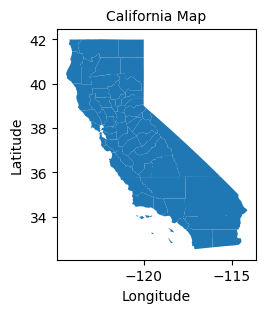

In [7]:
# This will be used as base for various spatial maps in this project; verify it is correct
ax = ca_county.plot(figsize=(9,3))
ax.set_title("California Map", fontsize=10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show();

<font color="purple"> <font size=4> Visual inspection of above plot confirms that ca_county has correct geometry for the state of California. </font>

## Spatial and Temporal Analysis of California Wildfires 1950-2025
- Historical CA Wildfire data consists of two datasets one from 1898-2023, another from 2024-2025.
- Data is in GeoJSON format.
- It contains one or more records for each wildfire incident.
- A wildfire record has infromation such as the fire start date, fire name, acres burned by the fire, geometry.
    - The geometry info is a polygon or a multipolygon of latitudes and longitudes marking the corresponding fire's perimeter.
    - There can be more than one record for each fire incident.
- Both these datasets are publicly available on California government website and have "Rights" listed as "No restrictions on public use".

**CA Fire data from 1898-2023:**
- External Link: https://data.ca.gov/dataset/california-fire-perimeters-1950
    - GeoJSON:https://data.ca.gov/dataset/california-fire-perimeters-1950/resource/62c3c56a-c79d-4480-8a85-f20667afdf74

**CA Fire data for 2024-Jan2025:**
- This data is no longer available on the original site. Data used by this project is available at the GitHub location below.
    - https://github.com/dpoonam/DataScience/tree/main/GeoScience/Wildfires/California/datasets/fire/CA/Selected 
- The CA government link below from which I had downloaded this data no longer works.
    - https://data.ca.gov/dataset/ca-perimeters-nifc-firis-public-view
- The data may have been moved to this new CA government link below but cannot confirm.
    - https://data.ca.gov/dataset/ca-perimeters-cal-fire-nifc-firis-public-view



### Read the two CA fire datasets, process them and concatenate them into one

In [11]:
# Helper function to read the GeoJSON wildfire data and do some basic processing
def read_fire_dataset(fileName, datasetName, dateColName):
    df = gpd.read_file(fileName)
    print("Dataset:", datasetName)
    print("\n Number of rows before processsing data:", len(df))
    df["fire_start_date"] = pd.to_datetime(df[dateColName])
    print("\n Data available from {} to {}".format(df["fire_start_date"].min(), df["fire_start_date"].max()))
    return df

In [12]:
# Read the 1898-2023 CA Wildfire GeoJSON data
fire1898 = read_fire_dataset("../datasets/fire/CA/Selected/California_Fire_Perimeters_(1950%2B).geojson", "California wildfires 1898-2023", 
                             "ALARM_DATE")
fire1898.rename(columns={"FIRE_NAME": "fire_name", "GIS_ACRES": "acres_burned"}, inplace=True)

# We are interested in acres_burned, fire start date, fire name, and geometry. drop any rows that have any of these set to NaN
fire1898.dropna(subset=["acres_burned", "fire_start_date", "fire_name", "geometry"], inplace=True, ignore_index=True)

# Append fire complex name to fire_name if the complex name is not NaN and not the same as fire name
fire1898["COMPLEX_NAME"] = fire1898["COMPLEX_NAME"].fillna("")
fire1898["fire_name"] = fire1898.apply(lambda row: row["fire_name"] + " " + row["COMPLEX_NAME"] 
                                       if row["fire_name"] != row["COMPLEX_NAME"] else row["fire_name"], axis=1)

# Keep only the columns of interest
fire1898 = fire1898[["fire_start_date", "fire_name", "acres_burned", "geometry"]]
fire1898.sort_values(by="fire_start_date", inplace=True, ignore_index=True)
print("\n Number of rows after processing data:", len(fire1898))

Dataset: California wildfires 1898-2023

 Number of rows before processsing data: 22261

 Data available from 1898-04-01 00:00:00+00:00 to 2023-12-22 00:00:00+00:00

 Number of rows after processing data: 16854


In [13]:
fire1898.head(3)

,fire_start_date,fire_name,acres_burned,geometry
0,1898-04-01 00:00:00+00:00,MATILIJA,2641.123,"POLYGON ((-119.27547 34.48999, -119.27583 34.4..."
1,1898-09-01 00:00:00+00:00,COZY DELL,2974.585,"POLYGON ((-119.23984 34.49126, -119.24023 34.4..."
2,1898-09-01 00:00:00+00:00,LOS PADRES,20539.950,"POLYGON ((-119.3393 34.47241, -119.33928 34.47..."


In [14]:
fire1898.tail(3)

,fire_start_date,fire_name,acres_burned,geometry
16851,2023-12-16 00:00:00+00:00,PANZA,3.066564,"MULTIPOLYGON (((-120.13459 35.38116, -120.1337..."
16852,2023-12-16 00:00:00+00:00,FRANKLIN,1.008626,"POLYGON ((-120.63869 35.58811, -120.63872 35.5..."
16853,2023-12-22 00:00:00+00:00,BORDER 42,38.605160,"POLYGON ((-116.76955 32.58624, -116.76953 32.5..."


In [15]:
# Read the 2024-2025 CA Wildfire GeoJSON data
fire2024 = read_fire_dataset("../datasets/fire/CA/Selected/CA_Perimeters_NIFC_FIRIS_public_view.geojson", 
                             "California wildfires 2024-2025", "FireDiscoveryDate")
fire2024.rename(columns={"incident_name": "fire_name", "area_acres": "acres_burned"}, inplace=True)
# We are interested in acres_burned, fire start date, fire name, and geometry. drop any rows that have any of these set to NaN
fire2024.dropna(subset=["acres_burned", "fire_start_date", "fire_name", "geometry"], inplace=True, ignore_index=True)
fire2024 = fire2024[["fire_start_date", "fire_name", "acres_burned", "geometry"]]
fire2024.sort_values(by="fire_start_date", inplace=True, ignore_index=True)
print("\n Number of rows after processing data:", len(fire2024))


Dataset: California wildfires 2024-2025

 Number of rows before processsing data: 1235

 Data available from 2024-02-11 04:33:27+00:00 to 2025-01-22 00:23:25+00:00

 Number of rows after processing data: 156


In [16]:
fire2024.head(3)

,fire_start_date,fire_name,acres_burned,geometry
0,2024-02-11 04:33:27+00:00,IRIS,10.41185,"POLYGON ((-115.5047 33.28874, -115.5047 33.288..."
1,2024-02-11 04:33:27+00:00,IRIS,7.80000,"POLYGON ((-115.5047 33.28874, -115.5047 33.288..."
2,2024-03-11 03:15:00+00:00,AVE 52,0.10000,"POLYGON ((-116.10881 33.67147, -116.10886 33.6..."


In [17]:
fire2024.tail(3)

,fire_start_date,fire_name,acres_burned,geometry
153,2025-01-07 18:38:00+00:00,PALISADES,21317.000000,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
154,2025-01-08 02:18:47+00:00,Eaton,14021.108712,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."
155,2025-01-22 00:23:25+00:00,CHANDLER,1.090000,"POLYGON ((-120.88144 39.95114, -120.88144 39.9..."


In [18]:
# Concatenate 1898-2023 and 2024-2025 fire datasets
cafire = pd.concat([fire1898, fire2024])
cafire.head(3)

,fire_start_date,fire_name,acres_burned,geometry
0,1898-04-01 00:00:00+00:00,MATILIJA,2641.123,"POLYGON ((-119.27547 34.48999, -119.27583 34.4..."
1,1898-09-01 00:00:00+00:00,COZY DELL,2974.585,"POLYGON ((-119.23984 34.49126, -119.24023 34.4..."
2,1898-09-01 00:00:00+00:00,LOS PADRES,20539.950,"POLYGON ((-119.3393 34.47241, -119.33928 34.47..."


In [19]:
cafire.tail(3)

,fire_start_date,fire_name,acres_burned,geometry
153,2025-01-07 18:38:00+00:00,PALISADES,21317.000000,"MULTIPOLYGON (((-118.56093 34.04408, -118.5609..."
154,2025-01-08 02:18:47+00:00,Eaton,14021.108712,"MULTIPOLYGON (((-118.08301 34.23769, -118.0830..."
155,2025-01-22 00:23:25+00:00,CHANDLER,1.090000,"POLYGON ((-120.88144 39.95114, -120.88144 39.9..."


In [20]:
# Add Year and Month column used by groupby later
cafire["year"] = cafire["fire_start_date"].dt.year
cafire["month"] = cafire["fire_start_date"].dt.month

# For this project, we will use only the fire records from 1950 onwards since we don't know how accurate the fire records
# are from before then
cafire = cafire[cafire["year"] >= 1950]
cafire.reset_index(inplace=True)

In [21]:
# Drop rows with empty fire_name or with only spaces
cafire = cafire[cafire["fire_name"].str.strip() != ""]

# Entries for the same fire incident could be using different case or number of white spaces in fire_name
# Make all fire_name upper case, remove leading and trailing white spaces, replace white spaces between characters with "_"
# This will allow us to find all duplicate fires in the next step
cafire["fire_name"] = cafire["fire_name"].str.upper().str.strip()
cafire["fire_name"] = cafire["fire_name"].str.replace(" ", "_")

# As the fire progresses, some fires may have multiple entries for different dates and acres burned.
# Remove duplicate entries, keeping only one row per fire with the max value for acres burned
# Since we are sorting in descending order by acres_burned, this will be the first entry in the duplicates
cafire = cafire.sort_values("acres_burned", ascending=False).drop_duplicates("fire_name", keep="first")
cafire.reset_index(inplace=True, drop=True)
cafire.head(3)

,index,fire_start_date,fire_name,acres_burned,geometry,year,month
0,15710,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8
1,16134,2021-07-14 00:00:00+00:00,DIXIE,963405.4,"MULTIPOLYGON (((-121.08903 40.32211, -121.0890...",2021,7
2,9580,2002-07-13 00:00:00+00:00,BISCUIT_BISCUIT_COMPLEX,501082.0,"POLYGON ((-123.79441 42.60736, -123.79254 42.6...",2002,7


In [22]:
print("Number of wildfire entries", cafire.shape[0])

Number of wildfire entries 8275


### Has there been a rise in the number of wildfires in California in recent years?

In [24]:
def linear_regression(x, y, show_eval_metrics=True):
    x2 = sm.add_constant(x)
    model_lr = sm.OLS(y,x2).fit()
    y_pred = model_lr.fittedvalues

    if show_eval_metrics:
        print("Linear regression model summary:\n", model_lr.summary())
        print("R^2: ", model_lr.rsquared)
        rmse_err = root_mean_squared_error(y, y_pred)
        print("RMSE: ",rmse_err)
    
    return y_pred

In [25]:
# Plot annual count of wildfires
def plot_ca_fire_count(title, groupby="year"):
    plt.figure(figsize=(50, 10))
    if groupby == "month":
        cafireCount = cafire.groupby("month").size().reset_index(name='count')
        plt.bar(cafireCount["month"], cafireCount["count"])
        plt.xlabel("Month", fontsize=30)
    else:
        cafireCount = cafire.groupby("year").size().reset_index(name='count')
        plt.bar(cafireCount["year"], cafireCount["count"])
        plt.xlabel("Year", fontsize=30)
        # Draw linear regression line with time (year) as the predictor
        t = 1 + (cafireCount["year"] - cafireCount["year"][0])
        data = np.squeeze(cafireCount["count"])
        y_pred = linear_regression(t, data, show_eval_metrics=False)
        plt.plot(cafireCount["year"], y_pred, "r--", label="Linear Regression Trend Line", linewidth=5)
        

    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.legend(fontsize=30)
    plt.ylabel("Count", fontsize=30)
    plt.title(title, fontsize=40)
    plt.grid(True)
    plt.show();

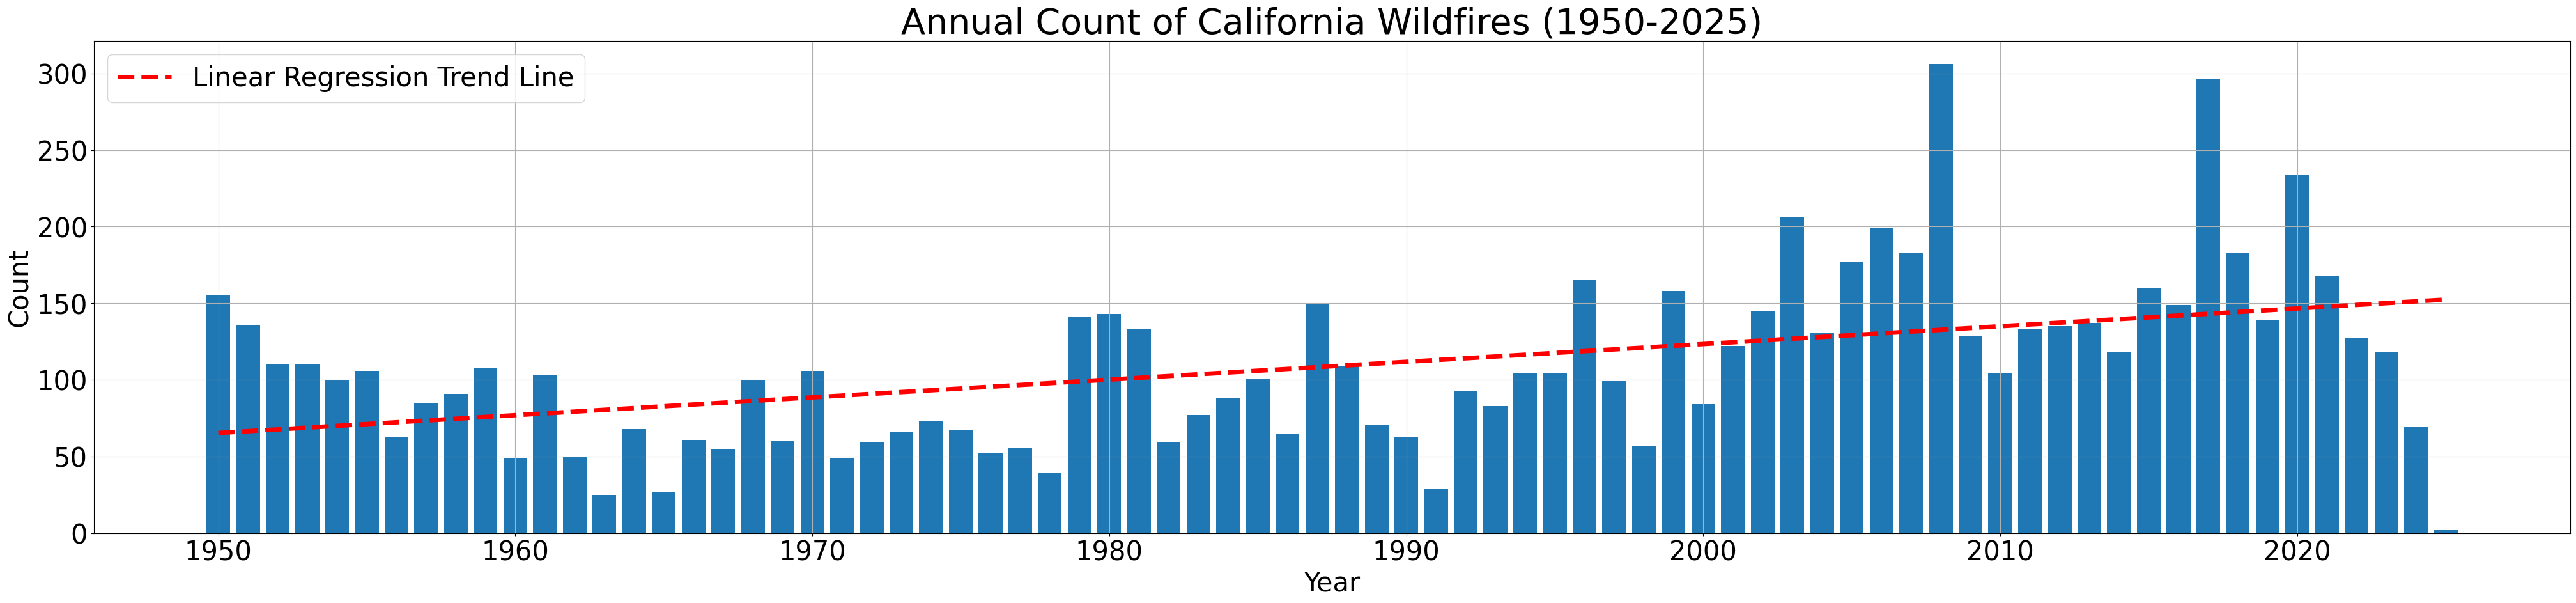

In [26]:
plot_ca_fire_count("Annual Count of California Wildfires (1950-2025)")

<font color="purple"> <font size=4> The trend line in the above plot suggests that there has been a rise in the annual count of wildfires in California in the recent years. </font>

<font color="red"> <font size=4>Note: Linear regression is used here solely to display the trend line. Therefore, I am not presenting evaluation metrics, residual plots, etc at this stage. A more comprehensive linear regression analysis is conducted later in the notebook. </font>

### Which months have the highest likelihood of wildfires occurring?

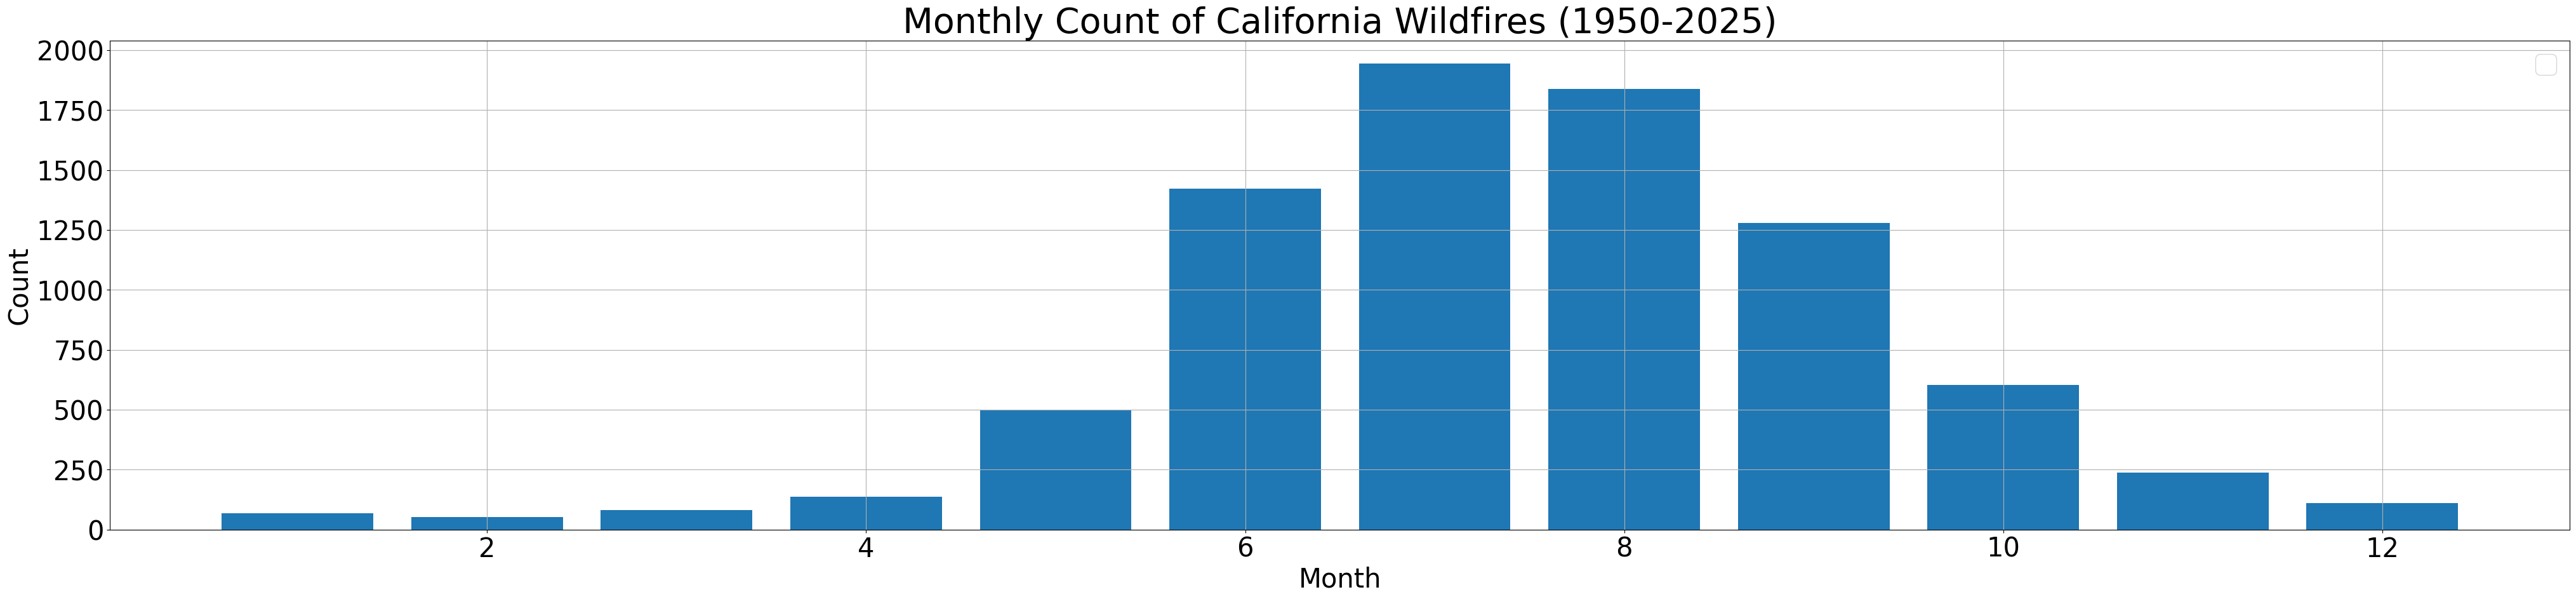

In [29]:
plot_ca_fire_count("Monthly Count of California Wildfires (1950-2025)", groupby="month")

<font color="purple"> <font size=4> Above plot suggests that most California wildfires occur during the summer (June to September) months.  </font>

### California Wildfires (1950-2025) Acres Burned Statistics

In [32]:
cafire["acres_burned"].describe()

count    8.275000e+03
mean     3.736548e+03
std      2.339400e+04
min      1.514838e-03
25%      4.215622e+01
50%      2.940373e+02
75%      1.123589e+03
max      1.032700e+06
Name: acres_burned, dtype: float64

In [33]:
# View the data statistics as a box plot
def box_plot_ca_fire(title, show_outliers=True):
    plt.figure(figsize=(50, 10))
    if show_outliers:
        plt.boxplot(cafire["acres_burned"], orientation="horizontal")
    else:
        plt.boxplot(cafire["acres_burned"], orientation="horizontal", sym='')
    plt.title(title, fontsize=40)
    plt.xlabel('Area (acres)', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.grid(True)
    plt.show();

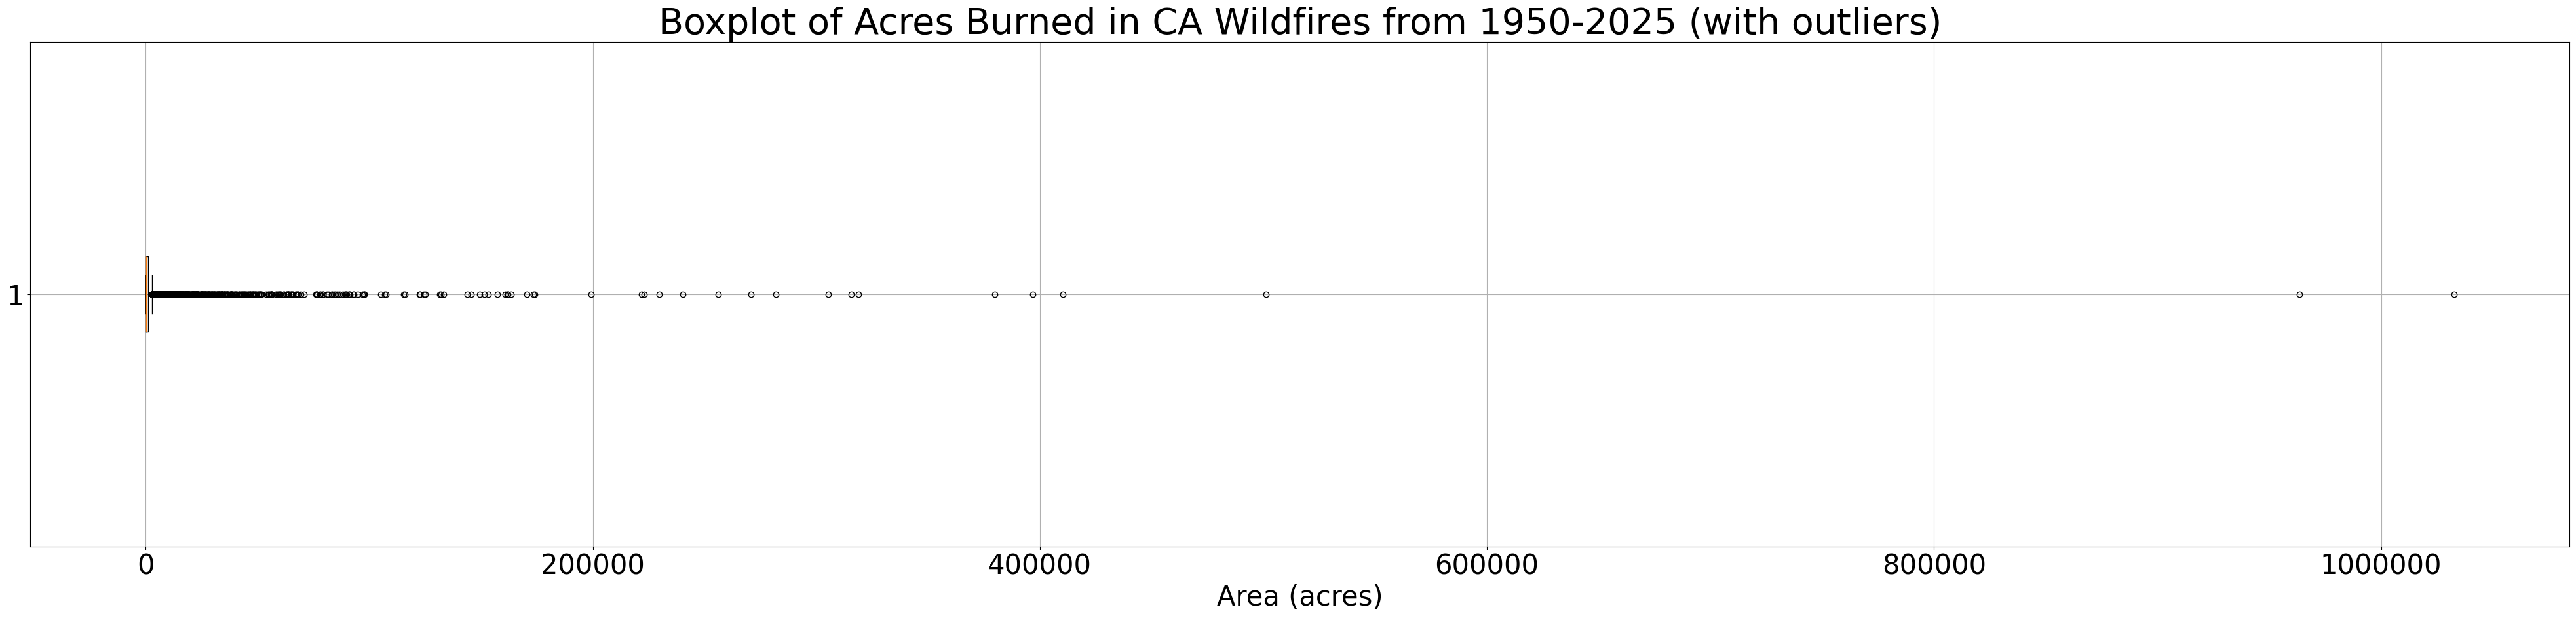

In [34]:
box_plot_ca_fire("Boxplot of Acres Burned in CA Wildfires from 1950-2025 (with outliers)")

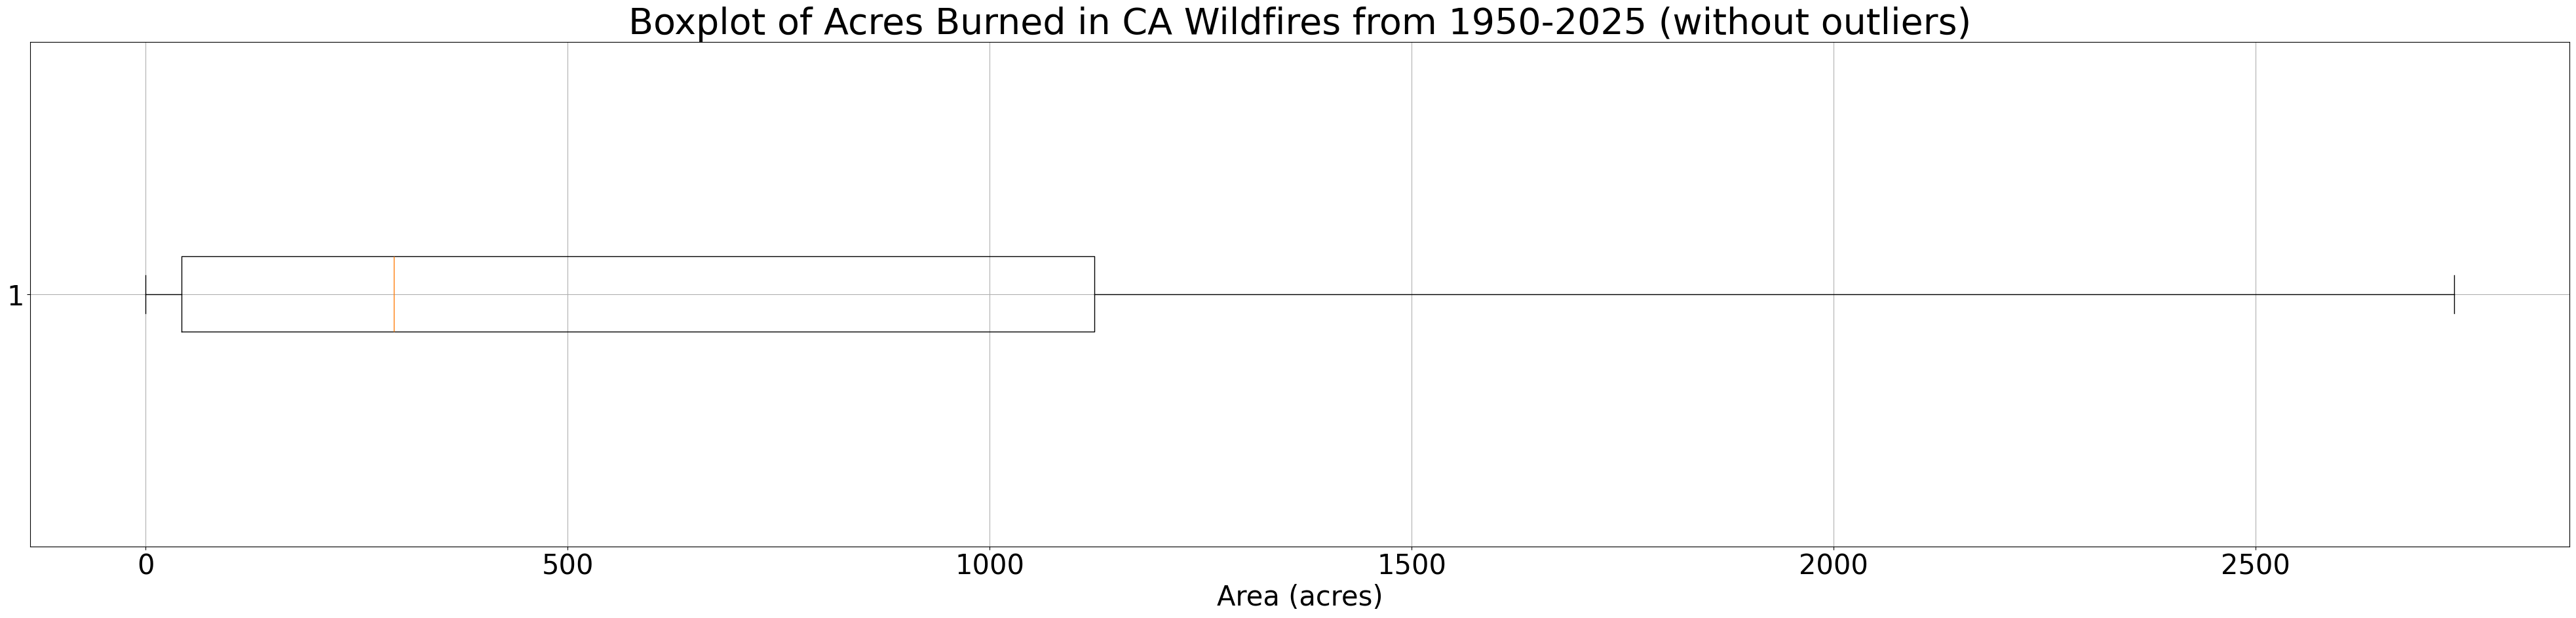

In [35]:
box_plot_ca_fire("Boxplot of Acres Burned in CA Wildfires from 1950-2025 (without outliers)", show_outliers=False)

<font color="purple"> <font size=4> The box plot and accompanying statistics indicate that 75% of California wildfires from 1950 to 2025 were smaller than 1,100 acres, with a median burned area of around 300 acres. However, there are many outliers on the higher end, as seen in the first box plot, including some wildfires that burned over 1 million acres. </font>

### Have wildfires in California grown in size and burned more acres in recent years?

In [38]:
# Plot annual total and average acres burned
def plot_ca_fire_acres_burned(title, to_plot="total", plot_linear_regression=True):

    plt.figure(figsize=(50, 10))
    # Skip 2025 since we don't have data for the full year yet.
    if to_plot == "mean":
        cafireMean = cafire[cafire["year"] < 2025].groupby("year")["acres_burned"].mean().reset_index(name='mean')
        if plot_linear_regression:
            # Draw linear regression line with time (year) as the predictor
            t = 1 + (cafireMean["year"] - cafireMean["year"][0])
            data = np.squeeze(cafireMean["mean"])
            y_pred = linear_regression(t, data, show_eval_metrics=False)
            plt.plot(cafireMean["year"], data, label="Mean", linewidth=4)
            plt.plot(cafireMean["year"], y_pred, "r--", label="Linear Regression Trend Line", linewidth=5)
    else:
        # Plot total by default
        cafireTotal = cafire[cafire["year"] < 2025].groupby("year")["acres_burned"].sum().reset_index(name='sum')
        if plot_linear_regression:
            # Draw linear regression line with time (year) as the predictor
            t = 1 + (cafireTotal["year"] - cafireTotal["year"][0])
            data = np.squeeze(cafireTotal["sum"])
            y_pred = linear_regression(t, data, show_eval_metrics=False)
            plt.plot(cafireTotal["year"], data, label="Total", linewidth=4)
            plt.plot(cafireTotal["year"], y_pred, "r--", label="Linear Regression Trend Line", linewidth=5)
    plt.legend(fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.xlabel("Years")
    plt.ylabel("Acres Burned", fontsize=30)
    plt.title(title, fontsize=40)
    plt.grid(True)
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

    plt.show();

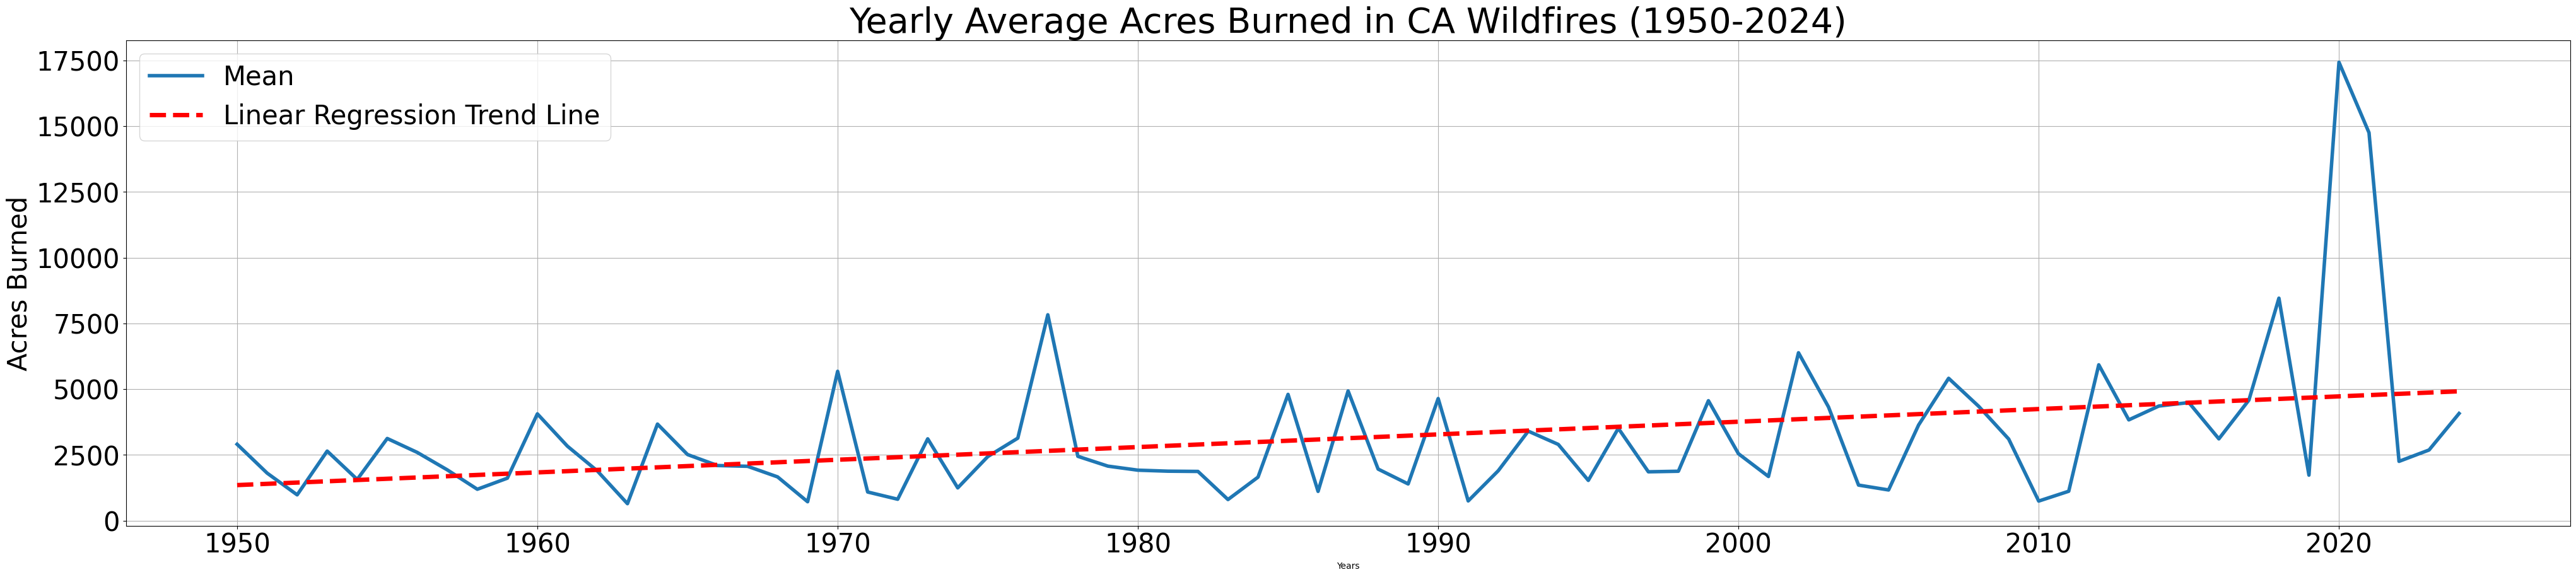

In [39]:
plot_ca_fire_acres_burned("Yearly Average Acres Burned in CA Wildfires (1950-2024)", to_plot="mean")

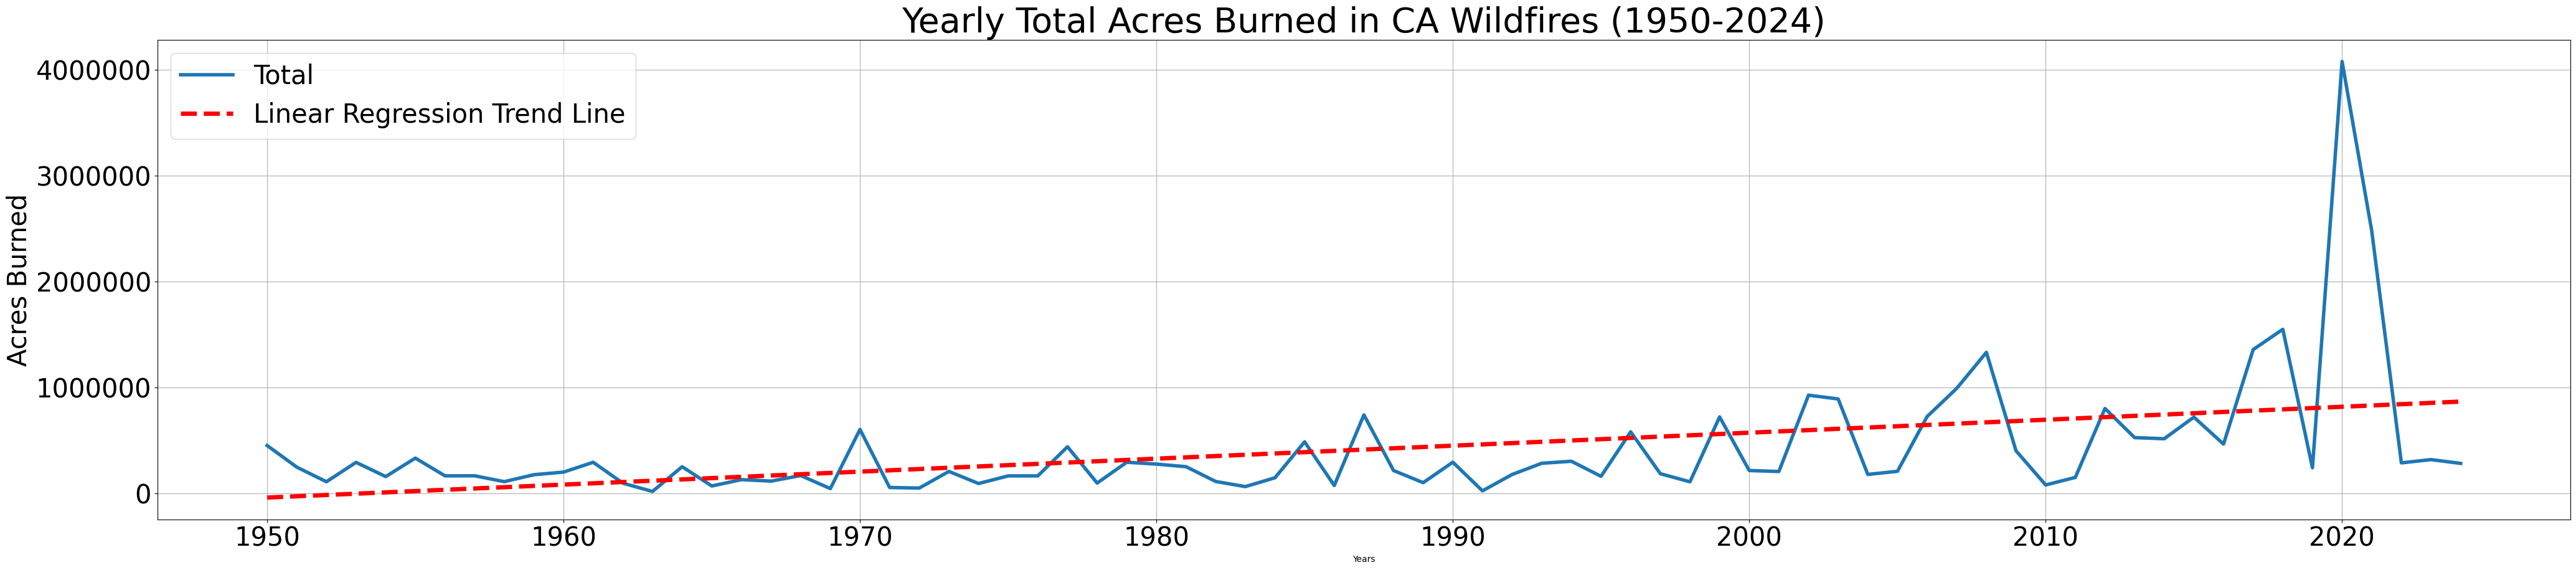

In [40]:
plot_ca_fire_acres_burned("Yearly Total Acres Burned in CA Wildfires (1950-2024)")

<font color="purple"> <font size=4> The trend line in the plots above indicates an upward trend in both the annual average and total acres burned by wildfires in California in recent years. </font>

<font color="red"> <font size=4> Note: Linear regression is used here solely to display the trend line. Therefore, I am not presenting evaluation metrics, residual plots, etc at this stage. A more comprehensive linear regression analysis is conducted later in the notebook. </font>

### When did the ten largest wildfires in California take place?

In [43]:
cafire.nlargest(10, "acres_burned").sort_values(by="acres_burned", ascending=False)[["year", "fire_name", "acres_burned"]]

,year,fire_name,acres_burned
0,2020,AUGUST_COMPLEX,1032700.0
1,2021,DIXIE,963405.4
2,2002,BISCUIT_BISCUIT_COMPLEX,501082.0
3,2018,RANCH_MENDOCINO_COMPLEX,410202.5
4,2020,SCU_COMPLEX,396824.5
5,2020,CREEK,379842.4
6,2020,NORTH_COMPLEX,318797.3
7,2012,RUSH,315511.5
8,2020,HENNESSEY_LNU_LIGHTNING_COMPLEX,305351.9
9,2017,THOMAS,281790.9


<font color="purple"> <font size=4> The table above indicates that nine of California's ten largest wildfires between 1950 and early 2025 occurred relatively recently, between 2017 and 2020.  </font>

### Are certain regions of California more prone to wildfires?

In [46]:
# ca_county data will be used to create the base map; cafire data will be overlayed on it.
# So first verify that both use the same coordinate reference system
ca_county.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [47]:
cafire.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

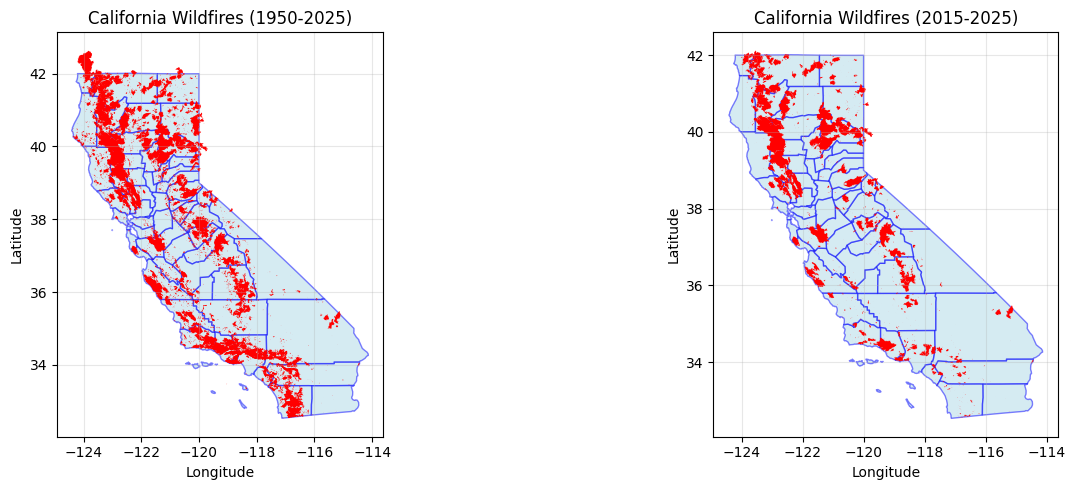

In [48]:
def map_ca_wildfires(ax, data_to_plot, title, display_county_names=False, display_cmap=False, col=None, display_fire_info=False):
    # First draw the base map
    ca_county.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.5)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Longitude", fontsize=10)
    ax.set_ylabel("Latitude", fontsize=10)
    ax.grid(alpha = 0.3)
    # Overlay the fire data on the base map
    if display_cmap and col:
        data_to_plot.plot(ax=ax, column=col, legend=True, edgecolor = "black", cmap="coolwarm")
    else:
        data_to_plot.plot(ax=ax, linewidth=1.5, facecolor="red")
        if display_fire_info:
            # Each fire record has a geometry info which is a polygon or multipolygon. Display fire name at the centroids of these polygons.
            data_to_plot.apply(lambda row: ax.text(row["geometry"].centroid.coords[0][0], 
                                                   row["geometry"].centroid.coords[0][1], row["fire_name"],
                                                   fontsize=5, ha='center', color='black'), axis=1)
            
    if display_county_names:
        ca_county.apply(lambda row: ax.text(row["geometry"].centroid.coords[0][0], row["geometry"].centroid.coords[0][1], row["county"],
                        fontsize=6, ha='center', color='black', family="serif"), axis=1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
# Plot 1950-2025 CA wildfires
map_ca_wildfires(axes[0], cafire, "California Wildfires (1950-2025)")
# Plot 2015-2025 CA wildfires
map_ca_wildfires(axes[1], cafire[(cafire["year"] >=2015) & (cafire["year"] <=2025)], "California Wildfires (2015-2025)")
plt.tight_layout()
plt.show();

In [49]:
# Add county info to wildfire data by doing a spatial join - based on intersection of the wild fire geometry and
# county geometry. A wildfire could intersect multiple counties in which case the inner join will duplicate the row for wildfire with
# one row for each county it intersects with.
ca_county_fires = gpd.sjoin(cafire, ca_county, how="inner", predicate="intersects")
ca_county_fires.drop(["index", "index_right"], axis=1, inplace=True)
ca_county_fires.head()

,fire_start_date,fire_name,acres_burned,geometry,year,month,county
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Lake
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Colusa
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Mendocino
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Glenn
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Tehama


In [50]:
# Calculate total number of wild fires, avg yearly count and acres burned for each county and
# add this data to the ca_county info
county_total_fires = ca_county_fires.groupby("county").size().reset_index(name="total_number_of_wild_fires_1950_2025")

county_count_per_year = ca_county_fires.groupby(["county", "year"]).size().reset_index(name="count_per_year")
county_avg_fires = county_count_per_year.groupby("county")["count_per_year"].mean().reset_index(name='avg_number_wildfires_per_year')

county_acres_per_year = ca_county_fires.groupby(["county", "year"])["acres_burned"].sum().reset_index(name="acres_burned_per_year")
county_avg_acres_fires = county_acres_per_year.groupby("county")["acres_burned_per_year"].mean().reset_index(name='avg_acres_burned_per_year')

ca_county_info = ca_county.merge(county_total_fires, on="county", how='left')
ca_county_info = ca_county_info.merge(county_avg_fires, on="county", how='left')
ca_county_info = ca_county_info.merge(county_avg_acres_fires, on="county", how='left')

ca_county_info.head()

,county,geometry,total_number_of_wild_fires_1950_2025,avg_number_wildfires_per_year,avg_acres_burned_per_year
0,Amador,"POLYGON ((-120.9955 38.2254, -121.02708 38.300...",50,1.428571,11530.860407
1,Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",59,1.966667,51280.019544
2,Lake,"POLYGON ((-122.6274 38.66751, -122.82159 38.85...",160,3.076923,49839.991222
3,Mariposa,"POLYGON ((-120.38767 37.63336, -120.38733 37.6...",221,3.507937,13931.539838
4,Napa,"POLYGON ((-122.10328 38.51335, -122.08884 38.3...",118,2.681818,23991.725035


In [51]:
print("Top 5 California counties with highest number of wildfires from 1950-2025:\n  ", 
      ca_county_info.nlargest(5, "total_number_of_wild_fires_1950_2025")[["county", "total_number_of_wild_fires_1950_2025"]])

Top 5 California counties with highest number of wildfires from 1950-2025:
            county  total_number_of_wild_fires_1950_2025
47  Los Angeles                                   732
17    San Diego                                   568
15    Riverside                                   430
53     Siskiyou                                   429
31         Kern                                   395


<font color="purple"> Except for the Siskiyou county, rest of the counties in the above list are in Southern California. </font>

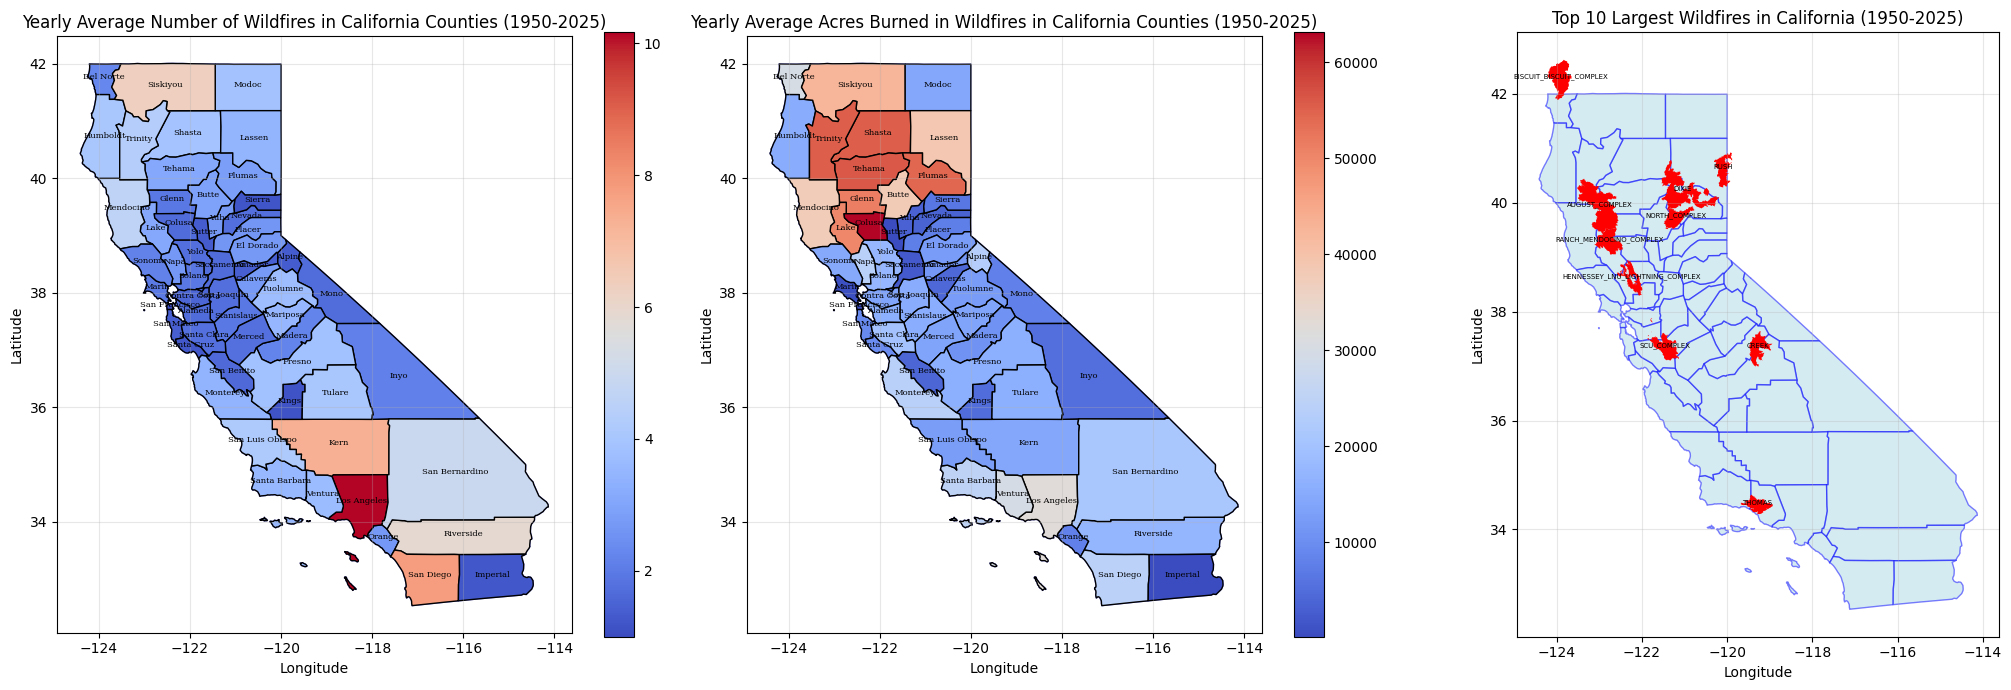

In [53]:
# Plot CA county map showing color bars for yearly average number of wildfires
# and yearly average of acres burned in each county
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,7))
map_ca_wildfires(axes[0], ca_county_info, "Yearly Average Number of Wildfires in California Counties (1950-2025)", display_county_names=True,
                 display_cmap=True, col="avg_number_wildfires_per_year")
map_ca_wildfires(axes[1], ca_county_info, "Yearly Average Acres Burned in Wildfires in California Counties (1950-2025)", 
                 display_county_names=True, display_cmap=True, col="avg_acres_burned_per_year")
map_ca_wildfires(axes[2], cafire.nlargest(10, "acres_burned"), "Top 10 Largest Wildfires in California (1950-2025)", 
                 display_county_names=False, display_fire_info=True)
plt.tight_layout()
plt.show();

<font color="purple"> <font size=4> - The map on the left indicates that Los Angeles, San Diego, and Kern counties in Southern California experienced the highest yearly average number of wildfires from 1950 to early 2025. </font>

<font color="purple"> <font size=4> - The map in the middle suggests that several counties in Northern California experienced the highest yearly average for acres burned in wildfires from 1950 to early 2025. </font>

<font color="purple"> <font size=4> - The map on the right shows that nine of California's ten largest wildfires between 1950 and early 2025 occurred in Northern California. </font>

<font color="purple"> <font size=4> - These maps suggest that Southern California tends to experience a higher number of wildfires on average, while Northern California sees fewer wildfires, but they tend to be larger in size. This is visual evaluation of the differences in wildfire characteristics in California. Next we will do statistical evaluation. </font>

### Are there any Statistical Differences in Wildfire Characteristics in Northern vs Southern California?

**Add a geographic region column to indicate whether the corresponding fire occured in the northern or southern CA.**

In [56]:
# According to this Wikipedia article https://en.wikipedia.org/wiki/Southern_California, following counties are part of southern CA
socal_counties = ["Imperial", "Kern", "Los Angeles", "Orange", "Riverside", "San Bernardino", "San Diego", "San Luis Obispo", 
                  "Santa Barbara", "Ventura"]

ca_county_info["geographic_region"] = ca_county_info["county"].apply(lambda x: "southern_california"
                                                                     if x in socal_counties else "northern_california")
ca_county_info.head(2)

,county,geometry,total_number_of_wild_fires_1950_2025,avg_number_wildfires_per_year,avg_acres_burned_per_year,geographic_region
0,Amador,"POLYGON ((-120.9955 38.2254, -121.02708 38.300...",50,1.428571,11530.860407,northern_california
1,Glenn,"POLYGON ((-122.93765 39.79816, -122.04647 39.7...",59,1.966667,51280.019544,northern_california


In [57]:
print("Number of counties in Southern California", len(ca_county_info[ca_county_info["geographic_region"] == "southern_california"]["county"]))

Number of counties in Southern California 10


In [58]:
print("Number of counties in Northern California",len(ca_county_info[ca_county_info["geographic_region"] == "northern_california"]["county"]))

Number of counties in Northern California 48


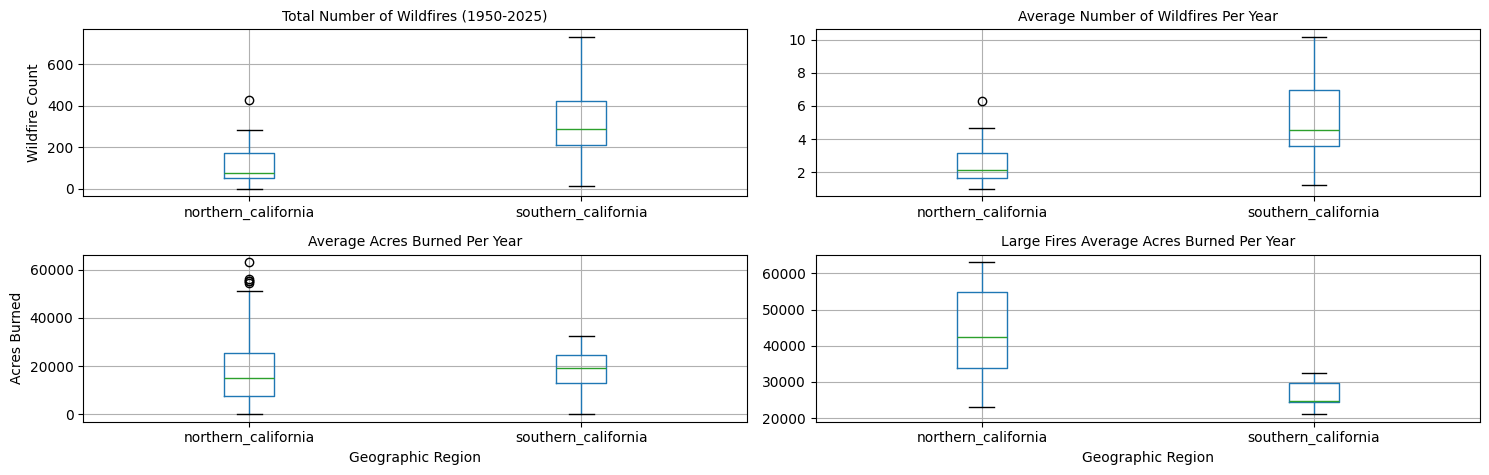

In [59]:
# View statistics by plotting the box plots
def plot_ca_geo_regions(ax, column, title, ylabel, show_xlabel=True, show_ylabel=True, acres_burned_threhsold=0):
    if not acres_burned_threhsold:
        ca_county_info.boxplot(by="geographic_region", column=column,ax=ax)
    else:
        # Plot data for large fires
        ca_county_info[ca_county_info["avg_acres_burned_per_year"] > acres_burned_threhsold].boxplot(by="geographic_region", 
                                                                                                     column=column,ax=ax)
    # Remove the default groupby title
    plt.suptitle('')
    if show_xlabel:
        ax.set_xlabel("Geographic Region", fontsize=10)
    else:
        # Do not show the default xlabel plotted by groupby
        ax.set_xlabel("")
    if show_ylabel:
        ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=10)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
plot_ca_geo_regions(axes[0][0], "total_number_of_wild_fires_1950_2025", "Total Number of Wildfires (1950-2025)", "Wildfire Count",
                    show_xlabel=False)
plot_ca_geo_regions(axes[0][1], "avg_number_wildfires_per_year", "Average Number of Wildfires Per Year", "Wildfire Count",
                   show_xlabel=False, show_ylabel=False)
plot_ca_geo_regions(axes[1][0], "avg_acres_burned_per_year", "Average Acres Burned Per Year", "Acres Burned")
plot_ca_geo_regions(axes[1][1], "avg_acres_burned_per_year", "Large Fires Average Acres Burned Per Year", "Acres Burned",
                    show_ylabel=False, acres_burned_threhsold=20000)

plt.tight_layout()
plt.show()

In [60]:
ca_county_info.groupby("geographic_region").describe()["total_number_of_wild_fires_1950_2025"]

,count,mean,std,min,25%,50%,75%,max
geographic_region,,,,,,,,
northern_california,48.0,116.9375,91.960307,1.0,50.75,77.5,173.75,429.0
southern_california,10.0,327.8000,213.112803,16.0,213.50,288.0,421.25,732.0


In [61]:
ca_county_info.groupby("geographic_region").describe()["avg_number_wildfires_per_year"]

,count,mean,std,min,25%,50%,75%,max
geographic_region,,,,,,,,
northern_california,48.0,2.495206,1.125773,1.000000,1.674020,2.141439,3.171903,6.308824
southern_california,10.0,5.144111,2.676404,1.230769,3.598861,4.565020,6.958714,10.166667


In [62]:
ca_county_info.groupby("geographic_region").describe()["avg_acres_burned_per_year"]

,count,mean,std,min,25%,50%,75%,max
geographic_region,,,,,,,,
northern_california,48.0,20438.700607,17620.015518,240.569626,7789.748941,15079.072580,25531.145814,63112.688440
southern_california,10.0,18511.530434,10030.372610,179.081890,13038.844607,19227.325605,24734.982104,32542.865732


In [63]:
ca_county_info[ca_county_info["avg_acres_burned_per_year"] > 20000].groupby("geographic_region").describe()["avg_acres_burned_per_year"]

,count,mean,std,min,25%,50%,75%,max
geographic_region,,,,,,,,
northern_california,15.0,42927.391586,13319.421333,23072.291512,33939.885255,42478.015991,54939.651281,63112.688440
southern_california,5.0,26537.424682,4544.861923,21159.592425,24404.653970,24845.091482,29734.919798,32542.865732


<font color="purple"> <font size=4> - The box plots and the descriptive statistics indicate that Southern California experienced a higher number of wildfires on average per year (median of 4.6 per year) compared to the average number of wildfires in Northern California (median of 2.14 per year) for the years 1950 to early 2025. </font>

<font color="purple"> <font size=4> - Southern California also has higher median of 19227 average acres burned per year compared to the median of 15079 average acres burner per year in the Northern California. However, Northern California experienced 15 large wildfires that burned more than 20,000 acres, compared to just 5 in Southern California. </font>


### Hypothesis Test: Does Southern California experience more wildfires on average per year compared to Northern California?

**Justification for performing hypothesis test:** The spatial map, box plot, and descriptive statistics suggest that Southern California experienced a higher average number of wildfires per year (median of 4.6) compared to Northern California (median of 2.14) between 1950 and early 2025. A hypothesis test will help determine whether this observed difference is supported by strong statistical evidence. </font>

<font color="red"> Note: Southern California makes up only about a third of California’s total area. What I am trying to understand is whether Southern California gets more wildfires for its size. This makes sense physically because Southern California is typically hotter, drier than Northern California and also experiences strong winds like the Santa Anas. All these factors favor higher wildfire activity. A better way to analyze whether Southern California gets more wildfires for its size would be to compare wildfire density (wildfires per unit area) using a statistical hypothesis test, but that is beyond the scope of this project. </font>

In [66]:
# Create seperate variables for Northern and Southern California 
geos = ca_county_info.groupby("geographic_region")
norcal = geos.get_group("northern_california")[["total_number_of_wild_fires_1950_2025", 
                                                "avg_number_wildfires_per_year", "avg_acres_burned_per_year"]]
socal = geos.get_group("southern_california")[["total_number_of_wild_fires_1950_2025", 
                                                "avg_number_wildfires_per_year", "avg_acres_burned_per_year"]]

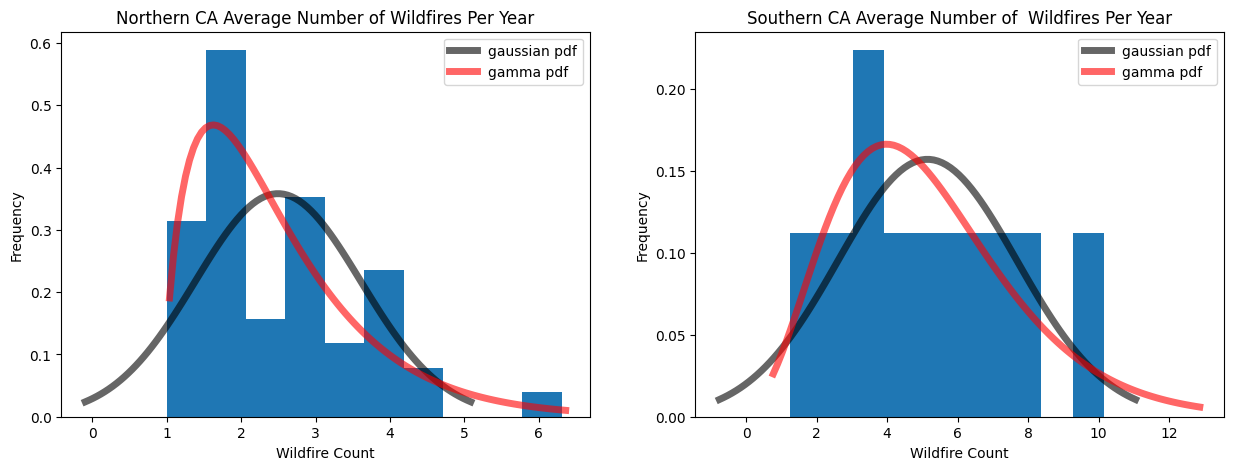

In [67]:
# Evaluate distributions as that will determine the choice of Hypothesis test
def plot_geo_dist(ax, data_to_plot, title, xlabel, ylabel, plot_gamma=True):
    ax.hist(data_to_plot, density=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Fit a normal distribution and plot it
    mu, std = stats.norm.fit(data_to_plot)
    x = np.linspace(stats.norm.ppf(0.01,mu,std), stats.norm.ppf(0.99,mu,std), 100)
    # Plot the normal distribution with the parameters we estimated from our data 
    ax.plot(x, stats.norm.pdf(x,mu,std), 'k-', lw=5, alpha=0.6, label='gaussian pdf')

    if plot_gamma:
        # For gamma distributions: THREE parameters
        alpha, loc, beta = stats.gamma.fit(data_to_plot)
        # Create the x-values 
        x = np.linspace(stats.gamma.ppf(0.01, alpha,loc,beta), stats.gamma.ppf(0.99, alpha,loc,beta), 100)
        # Plot the gamma distribution with the parameters we estimated from our data 
        ax.plot(x, stats.gamma.pdf(x,alpha,loc,beta), 'r-', lw=5, alpha=0.6, label='gamma pdf')
    ax.legend()


fig, axes = plt.subplots(1,2,figsize=(15,5))
plot_geo_dist(axes[0], norcal["avg_number_wildfires_per_year"], "Northern CA Average Number of Wildfires Per Year", 
              "Wildfire Count", "Frequency")
plot_geo_dist(axes[1], socal["avg_number_wildfires_per_year"], "Southern CA Average Number of  Wildfires Per Year", 
              "Wildfire Count", "Frequency")

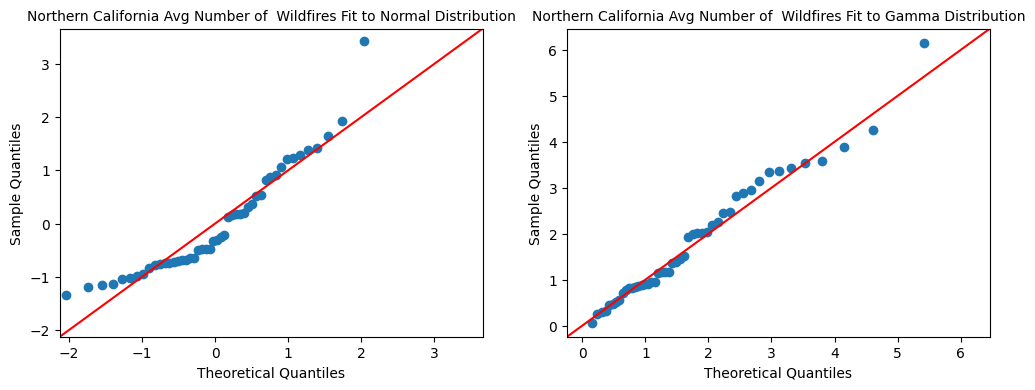

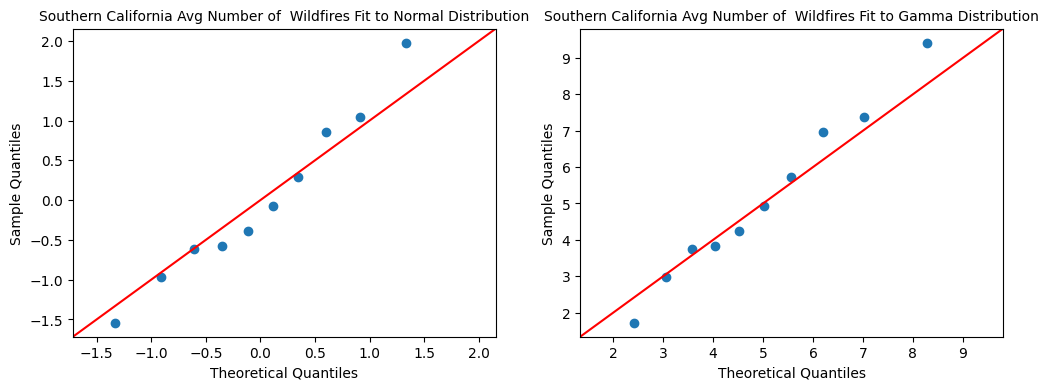

In [68]:
def plot_qq(ax, data_to_plot, distribution, title):
    if distribution == "normal":
        sm.qqplot(data_to_plot, fit=True, dist=stats.norm,line = '45', ax=ax)
    else:
        sm.qqplot(data_to_plot, fit=True, dist=stats.gamma,line = '45', ax=ax)
    ax.set_title(title, fontsize=10)


# Quantile-quantile plot - Fit to Normal and Gamma
fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_qq(axes[0], norcal["avg_number_wildfires_per_year"], "normal", 
        "Northern California Avg Number of  Wildfires Fit to Normal Distribution")
plot_qq(axes[1], norcal["avg_number_wildfires_per_year"], "gamma", 
        "Northern California Avg Number of  Wildfires Fit to Gamma Distribution")
plt.show()

fig, axes = plt.subplots(1,2,figsize=(12,4))
plot_qq(axes[0], socal["avg_number_wildfires_per_year"], "normal", 
        "Southern California Avg Number of  Wildfires Fit to Normal Distribution")
plot_qq(axes[1], socal["avg_number_wildfires_per_year"], "gamma", 
        "Southern California Avg Number of  Wildfires Fit to Gamma Distribution")
plt.show()



<font color="purple"> <font size=4> The histograms and Q-Q plots indicate that the gamma distribution provides a better fit, particularly for the average annual number of wildfires in Northern California. Therefore, we will use the Mann-Whitney hypothesis test.</font>

In [70]:
# Mann Whitney, since gamma distribution is a better fit

# Two-sided test.  Are the distributions different?
two_side = stats.mannwhitneyu(x=socal["avg_number_wildfires_per_year"], 
                              y=norcal["avg_number_wildfires_per_year"], alternative = 'two-sided')
print("Two-sided Hypothesis test result", two_side)
# REJECT the null, favor the alternate (distributions are different)

# One-sided test.  Is norcal distribution less than socal distribution?
one_side = stats.mannwhitneyu(x=norcal["avg_number_wildfires_per_year"], 
                              y=socal["avg_number_wildfires_per_year"], alternative = 'less')
print("One-sided Hypothesis test result",one_side)
# REJECT the null, favor the alternate (socal has more wildfires than norcal)

Two-sided Hypothesis test result MannwhitneyuResult(statistic=np.float64(392.5), pvalue=np.float64(0.0017545090006510981))
One-sided Hypothesis test result MannwhitneyuResult(statistic=np.float64(87.5), pvalue=np.float64(0.0008772545003255491))


<font color="purple"> <font size=4> p-value of the two-sided hypothesis test (0.0017) is less than the significance threshold of 0.05 so we reject the null hypothesis and favor the alternate. In other words, it is statistically significant and there is strong evidence that the two groups have different distributions. </font>

<font color="purple"> <font size=4> p-value of the one-sided hypothesis test (0.0008) is less than the significance threshold of 0.05 so we reject the null hypothesis and favor the alternate. In other words, it is statistically significant and there is strong evidence that Northern California tends to have fewer wildfires on average per year than Southern California. </font>

## How does California Weather affect the Wildfire activity?

We will use the California weather data mainly to identify potential correlations between weather conditions and wildfires. Therefore, we will not perform an extensive analysis of the weather data itself.

**California Weather Data:**
- Monthly precipitation and average temperature from 1895 to 2025 for 6 California divisons shown in the map below.
- Data is in CSV format.
- Each division has a seperate CSV file for a weather variable. E.g. each division has one file for precipitation and one file for avg temperatue. So total 12 CSV files for the 6 divisions.
- Each CSV file has:

      - 131 rows: one for each year from 1895 to 2025
      - 13 columns: 12 columns for each month and a column for year.
- Temperatures are in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
- Precipitation is in hundredths of an inch.  ie.  45 = 0.45",  257 = 2.57"
- External link to the data: From https://calclim.dri.edu/pages/tools.html follow the US Divisional Climate Data (http://www.wrcc.dri.edu/spi/divplot2map.html) link.
- This is a publicly available data from Calclim which is a joint venture of the Western Regional Climate Center and the Scripps Institution of Oceanography. I do not see any ethical concerns in using this data.


<img src="../datasets/weather_CA_divisions_1895_2025/CA_Divisions.png" alt="Drawing" style="width: 250px;"/>

### Read the average temperature and precipitation data for each CA division, process and combine them

In [74]:
# Seperate file for each of the precipitation, avg temp i.e. 2 files per division
# Therefore, total 12 files for 6 divisions
# Checkout a sample file 
pd.read_csv("../datasets/weather_CA_divisions_1895_2025/Central Coast/avg_temp_ccd - avg_temp_CCD.csv").head(3)

,Year,Jan.,Feb.,Mar.,Apr.,May,Jun.,Jul.,Aug.,Sep.,Oct.,Nov.,Dec.
0,1895,459,495,498,534,590,645,667,668,634,603,503,449
1,1896,490,500,516,490,561,648,673,672,624,604,494,495
2,1897,459,469,459,561,606,653,687,690,656,576,508,461


In [75]:
pd.read_csv("../datasets/weather_CA_divisions_1895_2025/Central Coast/avg_temp_ccd - avg_temp_CCD.csv").shape

(131, 13)

In [76]:
# Helper function to plot data
def plot_ca_div_data(data, title, ylabel):
        data.plot(grid=True, figsize=(15, 5), fontsize=15)
        plt.xlabel("Year", fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        plt.title(title, fontsize=20)
        plt.show();

# Helper function read specified data, perform basic processing and plot if needed
def analyze_ca_division_weather(file_name, title, ylabel, show_plot=False):
    df = pd.read_csv(file_name)
    df.set_index("Year", inplace=True)
    # Drop last row for 2025 since we do not have data for the full year yet
    df = df.iloc[:-1]
    # Temperature in tenths of deg. Fahrenheit.  ie.  -35 = -3.5 F,  557 = 55.7 F
    # Precipitation in hundredths of an inch.  ie.  45 = 0.45",  257 = 2.57" 
    df = df/10
    if "Precipitation" in ylabel:
        df = df/10
    if show_plot:
        plot_ca_div_data(df.mean(axis=1), title, ylabel)
        print("\n Sample Data: \n", df.head(3))
        print("\n Descriptive Statistics: \n", df.describe())
    return df

# Helper function to read and combine data for the user specified climate variable for all CA divisions
def combine_ca_division_weather_data(variable, title, ylabel, data_dir):
    all_divisions = pd.DataFrame()
    for subdir in os.listdir(data_dir):
        subdir_p = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_p):
            division = subdir
            #print("CA Division: ", division)
            for file_name in os.listdir(subdir_p):
                if variable in file_name and file_name.endswith('.csv'):
                    file_path = os.path.join(subdir_p, file_name)
                    df = analyze_ca_division_weather(file_path, title + " for " + division, ylabel)
                    # Keep only the annual average
                    df[division] = df.mean(axis=1)
                    df = df[[division]]
                    #print(df.head())
                    if all_divisions.empty:
                        all_divisions = df.copy()
                    else:
                        all_divisions = pd.concat([all_divisions, df], axis=1)
                        
    return all_divisions

In [77]:
# Read avg temp data for all 6 CA divisions and combine them into one dataframe
ca_avg_temps = combine_ca_division_weather_data("avg_temp", "Annual Average Temperature", "Temperature (F)",
                                                "../datasets/weather_CA_divisions_1895_2025/")
ca_avg_temps.head()

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
Year,,,,,,
1895,63.191667,57.816667,51.083333,56.208333,53.608333,55.075000
1896,64.791667,59.075000,51.583333,56.391667,54.425000,55.975000
1897,63.000000,57.675000,51.191667,56.541667,53.541667,55.383333
1898,63.850000,58.241667,50.925000,56.408333,53.125000,55.750000
1899,63.516667,57.866667,50.683333,56.816667,52.775000,56.183333


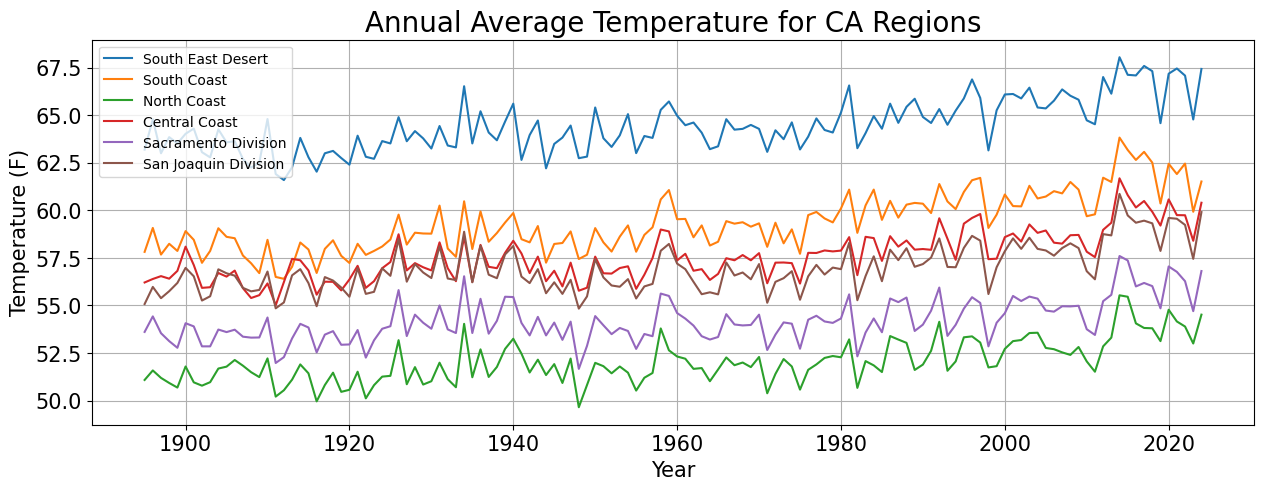

In [78]:
plot_ca_div_data(ca_avg_temps, "Annual Average Temperature for CA Regions", "Temperature (F)")

In [79]:
# Read precipitation data for all 6 CA divisions and combine them into one dataframe
ca_precipitation = combine_ca_division_weather_data("precipitation", "Annual Precipitation", "Precipitation (in)",
                                                     "../datasets/weather_CA_divisions_1895_2025/")
ca_precipitation.head()

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division
Year,,,,,,
1895,0.505833,1.560000,3.868333,1.685833,3.144167,1.781667
1896,0.532500,1.341667,5.500000,2.186667,4.311667,2.178333
1897,0.625000,1.408333,3.665833,1.458333,2.814167,1.764167
1898,0.320000,0.659167,2.490000,0.767500,1.646667,0.845000
1899,0.317500,1.028333,4.879167,2.041667,3.620000,1.882500


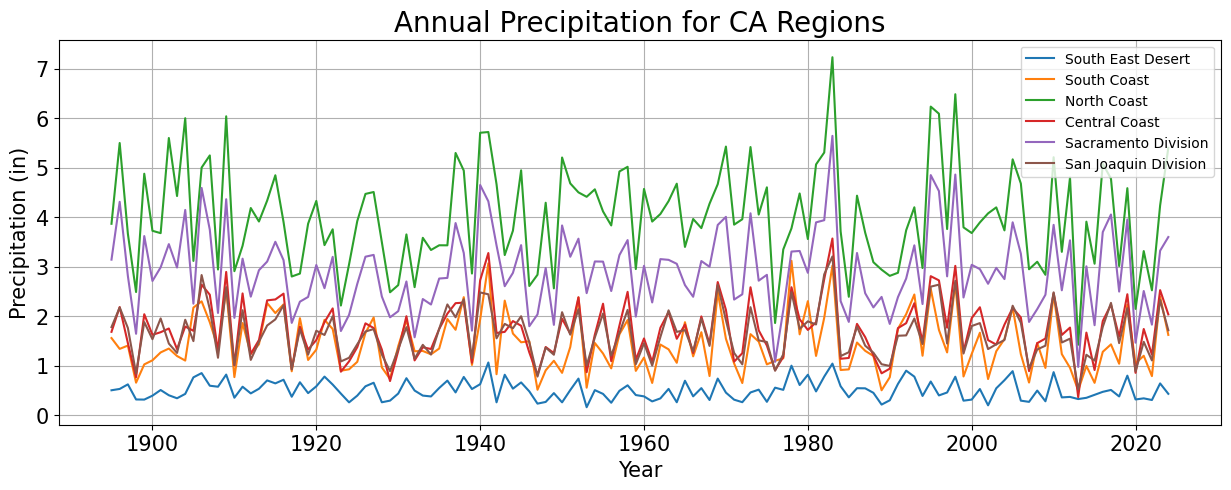

In [80]:
plot_ca_div_data(ca_precipitation, "Annual Precipitation for CA Regions", "Precipitation (in)")

### Average Temperature and Precipitation Variability: Northern vs. Southern California

In [82]:
# Categorize the data into southern and northern california
# We don't have county info in this data to exactly demarcate the line between the southern
# and northern part of the state but looking at the map in this Wikipedia arcticle https://en.wikipedia.org/wiki/Southern_California
# we can say that south east desert and south coast are part of southern CA
ca_avg_temps["northern_california"] = (ca_avg_temps["North Coast"] + ca_avg_temps["Central Coast"] + 
                                       ca_avg_temps["Sacramento Division"] + ca_avg_temps["San Joaquin Division"])/4
ca_avg_temps["southern_california"] = (ca_avg_temps["South Coast"] + ca_avg_temps["South East Desert"])/2
ca_avg_temps.head(3)

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division,northern_california,southern_california
Year,,,,,,,,
1895,63.191667,57.816667,51.083333,56.208333,53.608333,55.075000,53.993750,60.504167
1896,64.791667,59.075000,51.583333,56.391667,54.425000,55.975000,54.593750,61.933333
1897,63.000000,57.675000,51.191667,56.541667,53.541667,55.383333,54.164583,60.337500


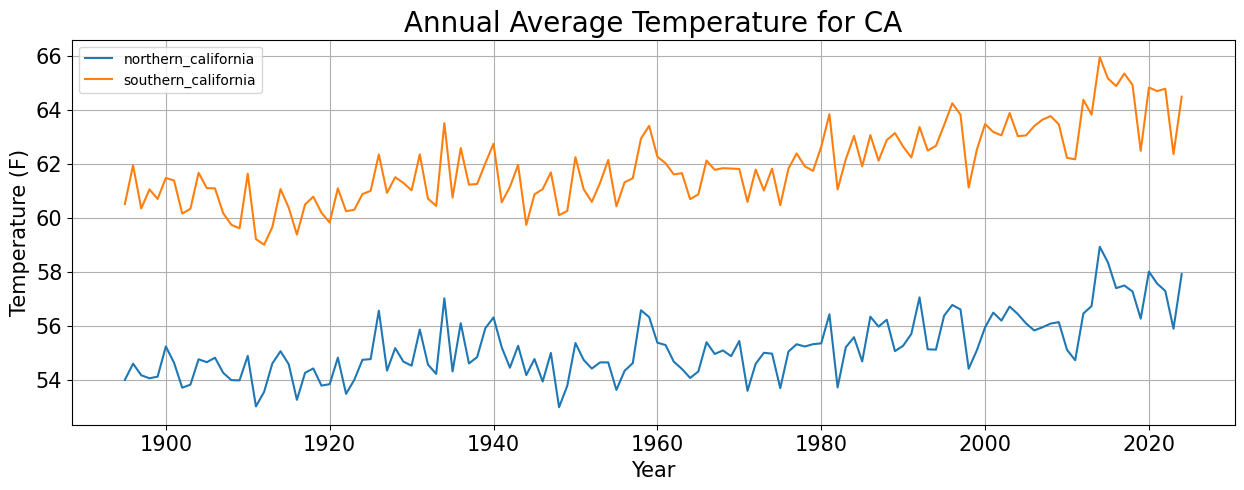

In [83]:
plot_ca_div_data(ca_avg_temps[["northern_california", "southern_california"]], "Annual Average Temperature for CA", "Temperature (F)")

In [84]:
# Take spatial average of precipitation
ca_precipitation["northern_california"] = (ca_precipitation["North Coast"] + ca_precipitation["Central Coast"] + 
                                       ca_precipitation["Sacramento Division"] + ca_precipitation["San Joaquin Division"])/4
ca_precipitation["southern_california"] = (ca_precipitation["South Coast"] + ca_precipitation["South East Desert"])/2
ca_precipitation.head(3)

,South East Desert,South Coast,North Coast,Central Coast,Sacramento Division,San Joaquin Division,northern_california,southern_california
Year,,,,,,,,
1895,0.505833,1.560000,3.868333,1.685833,3.144167,1.781667,2.620000,1.032917
1896,0.532500,1.341667,5.500000,2.186667,4.311667,2.178333,3.544167,0.937083
1897,0.625000,1.408333,3.665833,1.458333,2.814167,1.764167,2.425625,1.016667


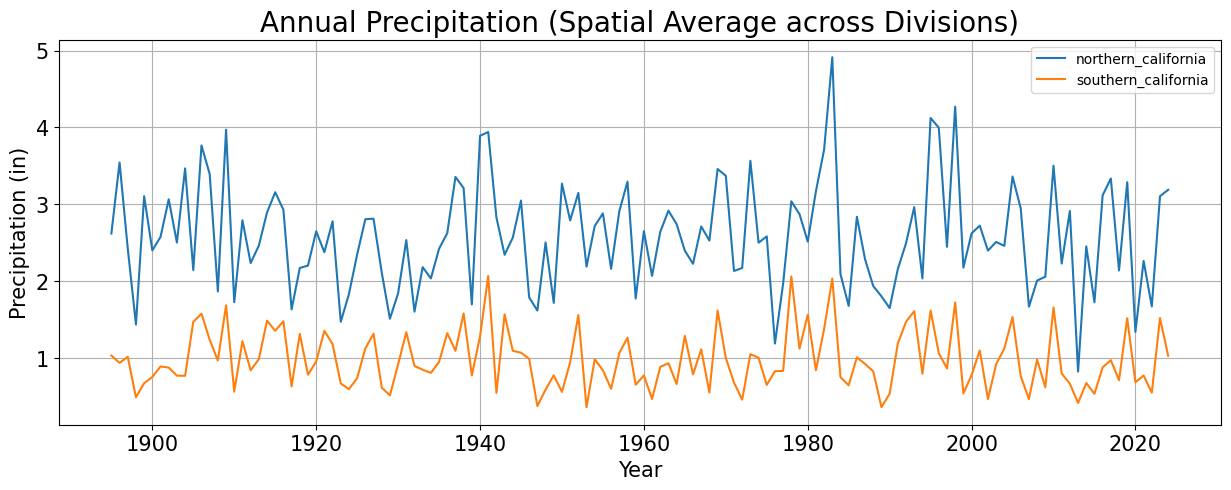

In [85]:
plot_ca_div_data(ca_precipitation[["northern_california", "southern_california"]], "Annual Precipitation (Spatial Average across Divisions)", 
                                   "Precipitation (in)")

<font color="purple"> <font size=4> The plots indicate that Southern California tends to receive less precipitation and has higher average temperatures compared to Northern California. This aligns with general meteorological patterns for the region.  </font>

### How has the average temperature and precipitation in California changed from 1895 to 2025?

In [88]:
# Combine the temp and precipitation data into a single data frame
ca_weather = ca_avg_temps[["northern_california", "southern_california"]]
ca_weather.rename(columns={"northern_california": "northern_california_avg_temp", 
                           "southern_california": "southern_california_avg_temp"}, inplace=True)
ca_weather["northern_california_precip"] = ca_precipitation["northern_california"]
ca_weather["southern_california_precip"] = ca_precipitation["southern_california"]
# Add columns for avg temp and precipitation for the entire state
ca_weather["avg_temp"] = round((ca_weather["northern_california_avg_temp"] + ca_weather["southern_california_avg_temp"])/2, 2)
ca_weather["precip"] = round((ca_weather["northern_california_precip"] + ca_weather["southern_california_precip"])/2, 2)
ca_weather.head()

,northern_california_avg_temp,southern_california_avg_temp,northern_california_precip,southern_california_precip,avg_temp,precip
Year,,,,,,
1895,53.993750,60.504167,2.620000,1.032917,57.25,1.83
1896,54.593750,61.933333,3.544167,0.937083,58.26,2.24
1897,54.164583,60.337500,2.425625,1.016667,57.25,1.72
1898,54.052083,61.045833,1.437292,0.489583,57.55,0.96
1899,54.114583,60.691667,3.105833,0.672917,57.40,1.89


In [89]:
# Plot annual weather
def plot_ca_weather(variable, title, label, ylabel, rolling_window=15):
    plt.figure(figsize=(50, 10))
    plt.plot(ca_weather.index, ca_weather[variable], linewidth=4, label=label)
    rolling = ca_weather.rolling(rolling_window, center=False).mean()
    plt.plot(rolling.index, rolling[variable], "r-", label="Rolling " + str(rolling_window) + " Year Average", linewidth=3)
    plt.xlabel("Year", fontsize=30)
    plt.legend(fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ylabel(ylabel, fontsize=30)
    plt.title(title, fontsize=40)
    plt.grid(True)
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)

    plt.show();

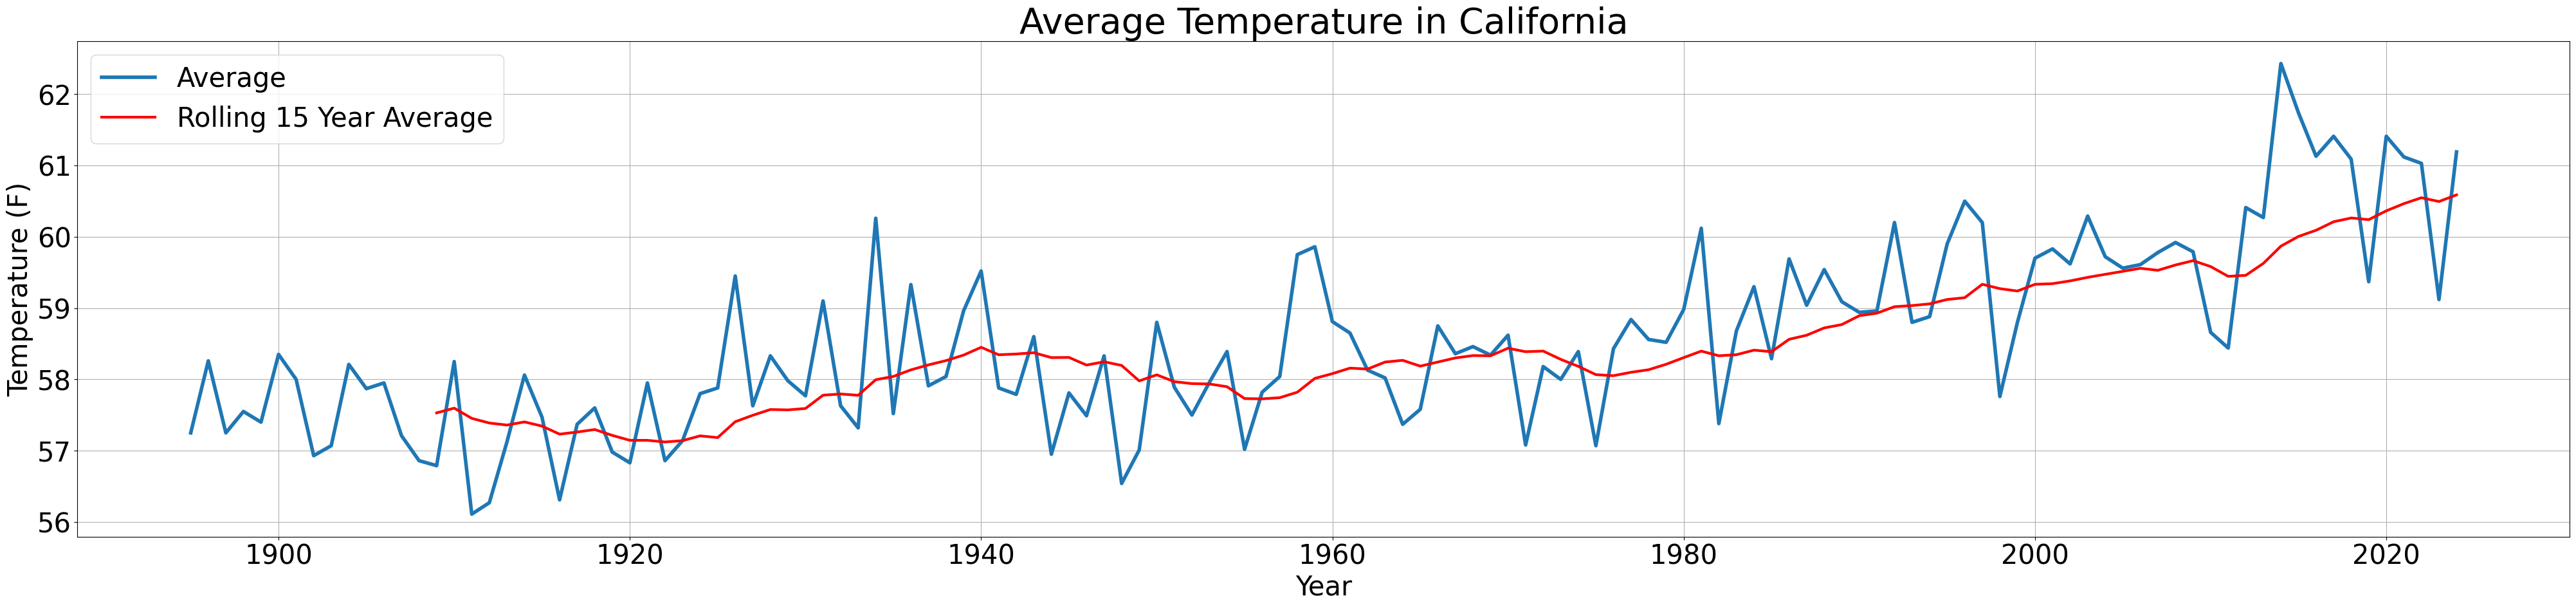

In [90]:
plot_ca_weather("avg_temp", "Average Temperature in California", "Average", "Temperature (F)", rolling_window=15)

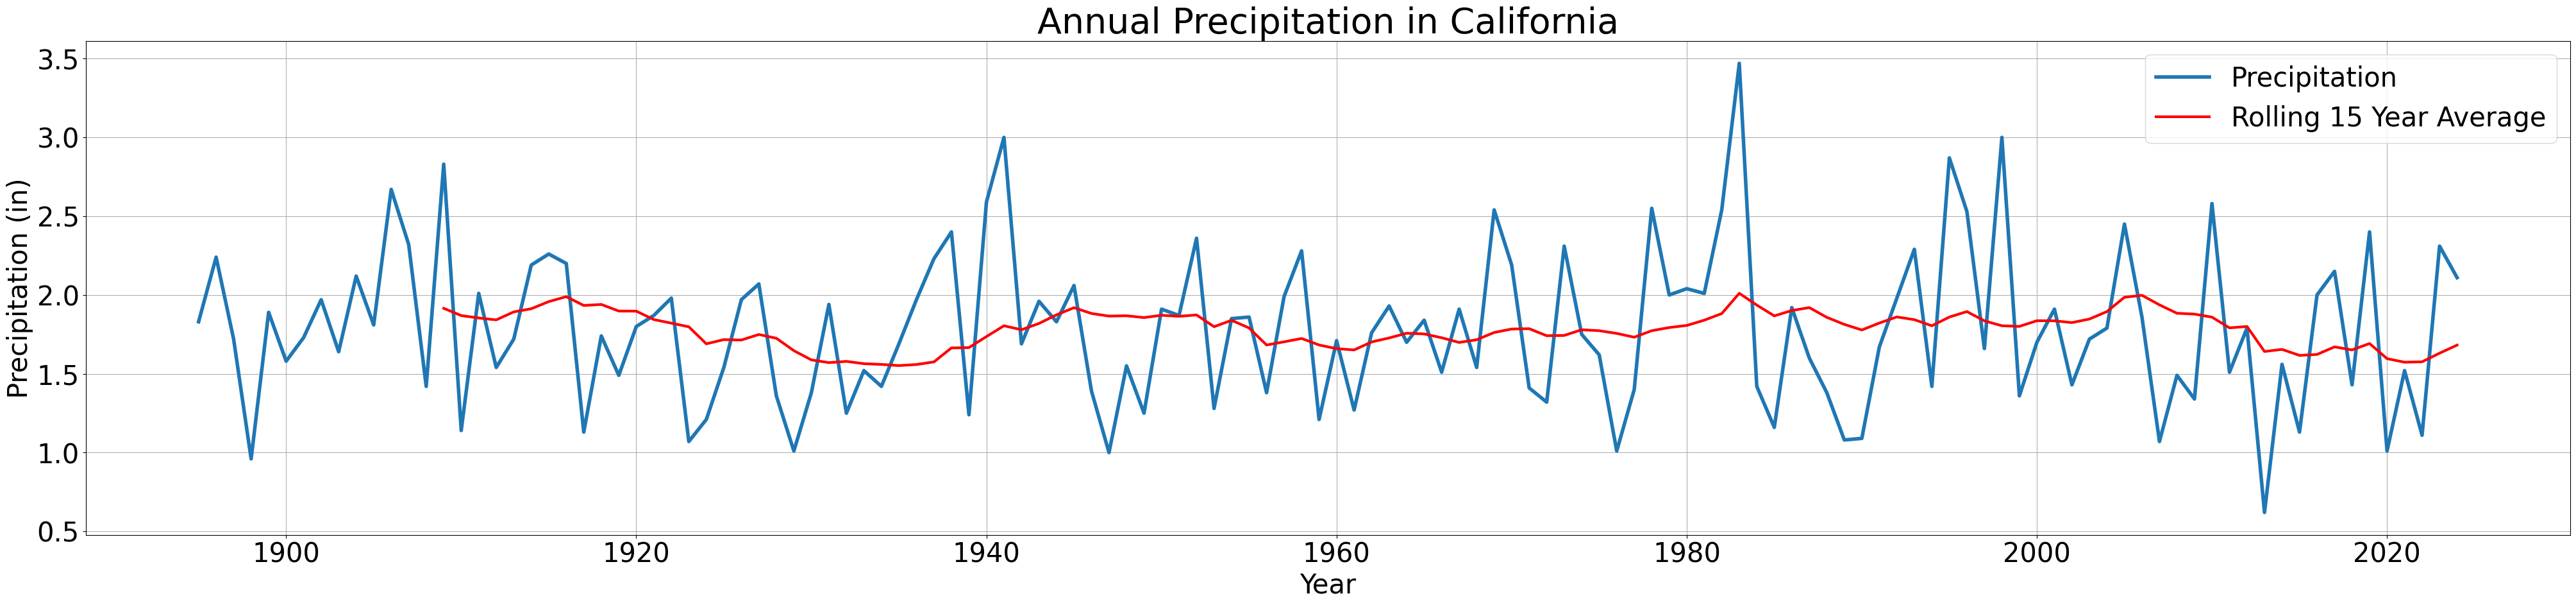

In [91]:
plot_ca_weather("precip", "Annual Precipitation in California", "Precipitation", "Precipitation (in)", rolling_window=15)

<font color="purple"> <font size=4> Above plots indicate that average temperature has steadily increased in California over the years especially since 1970s while there has been no significant change in the precipitation patterns since 1900. </font>

<font color="purple"> <font size=4> I smoothed the data using the moving window average to reduce noise and make it easier to identify the trend. The 15 year average was selected after experimenting with various numbers. The 15 year window was found to reduce enough noise without removing too much signal. </font>


### Correlation between California Weather and Wildfires

<font color="purple"> <font size=4> As we saw earlier, Northern and Southern CA have different weather and wildfire characteristics. So,  we will look at correlations between weather and wildfire in each region seperately as well as for the entire state of California. </font>

In [94]:
ca_weather.head(2)

,northern_california_avg_temp,southern_california_avg_temp,northern_california_precip,southern_california_precip,avg_temp,precip
Year,,,,,,
1895,53.99375,60.504167,2.620000,1.032917,57.25,1.83
1896,54.59375,61.933333,3.544167,0.937083,58.26,2.24


In [95]:
ca_county_fires.head(2)

,fire_start_date,fire_name,acres_burned,geometry,year,month,county
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Lake
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Colusa


In [96]:
ca_county_fires["geographic_region"] = ca_county_fires["county"].apply(lambda x: "southern_california"
                                                                     if x in socal_counties else "northern_california")
ca_county_fires.head(2)

,fire_start_date,fire_name,acres_burned,geometry,year,month,county,geographic_region
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Lake,northern_california
0,2020-08-16 00:00:00+00:00,AUGUST_COMPLEX,1032700.0,"MULTIPOLYGON (((-122.70908 39.37205, -122.7105...",2020,8,Colusa,northern_california


In [97]:
# Create a dataframe such that year is index and there is a column for avg acres burned for each year in socal and
# northern California 
# Since there can be multiple entries for same fire for each county, we drop all but one, so that the same fire does not get
# counted twice. Note the acres_burned for each of these duplicate entries will be the same because of the processing
# that was done earlier.Therefore, we are not losing any info by dropping the duplicates. 
temp_df = ca_county_fires.drop_duplicates("fire_name", keep='first')
region_fires = temp_df.groupby(["geographic_region", "year"])["acres_burned"].mean().unstack("geographic_region")
region_fires.rename(columns={"northern_california": "northern_ca_avg_acres_burned",
                             "southern_california": "southern_ca_avg_acres_burned"}, inplace=True)
region_fires.head()

geographic_region,northern_ca_avg_acres_burned,southern_ca_avg_acres_burned
year,,
1950,2251.981014,5511.642558
1951,1684.119325,2377.736872
1952,1014.959595,802.463895
1953,932.354370,5761.761700
1954,1445.209102,1971.919619


In [98]:
# Add column for total number of fires per year
temp_df_1 = temp_df.groupby(["geographic_region", "year"]).size().unstack("geographic_region")
temp_df_1.rename(columns={"northern_california": "northern_ca_fire_count",
                             "southern_california": "southern_ca_fire_count"}, inplace=True)
temp_df_1.head(2)

geographic_region,northern_ca_fire_count,southern_ca_fire_count
year,,
1950,124.0,31.0
1951,112.0,24.0


In [99]:
region_fires = region_fires.join(temp_df_1)
region_fires.head(2)

geographic_region,northern_ca_avg_acres_burned,southern_ca_avg_acres_burned,northern_ca_fire_count,southern_ca_fire_count
year,,,,
1950,2251.981014,5511.642558,124.0,31.0
1951,1684.119325,2377.736872,112.0,24.0


In [100]:
# Create a single dataframe for fire and weather for the common years 1950-2024
ca_fire_weather = region_fires[region_fires.index < 2025].join(ca_weather[ca_weather.index > 1949])

# Display transpose so that we can see all columns
ca_fire_weather.head(2).transpose()

year,1950,1951
northern_ca_avg_acres_burned,2251.981014,1684.119325
southern_ca_avg_acres_burned,5511.642558,2377.736872
northern_ca_fire_count,124.000000,112.000000
southern_ca_fire_count,31.000000,24.000000
northern_california_avg_temp,55.356250,54.733333
southern_california_avg_temp,62.237500,61.054167
northern_california_precip,3.268750,2.790833
southern_california_precip,0.559583,0.944583
avg_temp,58.800000,57.890000
precip,1.910000,1.870000


In [101]:
ca_fire_weather.tail(2).transpose()

year,2023,2024
northern_ca_avg_acres_burned,3119.513288,5217.852151
southern_ca_avg_acres_burned,2205.721864,3670.821754
northern_ca_fire_count,62.000000,18.000000
southern_ca_fire_count,56.000000,51.000000
northern_california_avg_temp,55.887500,57.908333
southern_california_avg_temp,62.350000,64.475000
northern_california_precip,3.105417,3.189583
southern_california_precip,1.520417,1.029167
avg_temp,59.120000,61.190000
precip,2.310000,2.110000


In [102]:
# Create seperate dataframes for Northern CA, Southern CA and the entire state of CA to make it easy
# to view scatter plots, heatmaps for each seperately
norcal = ca_fire_weather[["northern_ca_avg_acres_burned", "northern_ca_fire_count", "northern_california_avg_temp", 
                         "northern_california_precip"]]
norcal.rename(columns={"northern_ca_avg_acres_burned":"avg_acres_burned", "northern_ca_fire_count": "fire_count",
                       "northern_california_avg_temp": "avg_temp", "northern_california_precip": "precip"}, inplace=True)
norcal.head(2)

,avg_acres_burned,fire_count,avg_temp,precip
year,,,,
1950,2251.981014,124.0,55.356250,3.268750
1951,1684.119325,112.0,54.733333,2.790833


In [103]:
socal = ca_fire_weather[["southern_ca_avg_acres_burned", "southern_ca_fire_count", "southern_california_avg_temp", 
                         "southern_california_precip"]]
socal.rename(columns={"southern_ca_avg_acres_burned":"avg_acres_burned", "southern_ca_fire_count": "fire_count",
                       "southern_california_avg_temp": "avg_temp", "southern_california_precip": "precip"}, inplace=True)
socal.head(2)

,avg_acres_burned,fire_count,avg_temp,precip
year,,,,
1950,5511.642558,31.0,62.237500,0.559583
1951,2377.736872,24.0,61.054167,0.944583


In [104]:
ca = ca_weather[["avg_temp", "precip"]][ca_weather.index > 1949]
ca["fire_count"] = cafire[cafire["year"] < 2025].groupby("year").size().rename("fire_count")
ca["avg_acres_burned"] = cafire[cafire["year"] < 2025].groupby("year")["acres_burned"].mean().rename("avg_acres_burned")
# Reorder the columns so that they are in the same order as the norcal and socal dataframes; makes it ease to view
ca = ca[["avg_acres_burned", "fire_count", "avg_temp", "precip"]]
ca.head(2)

,avg_acres_burned,fire_count,avg_temp,precip
Year,,,,
1950,2903.913323,155,58.80,1.91
1951,1806.522422,136,57.89,1.87


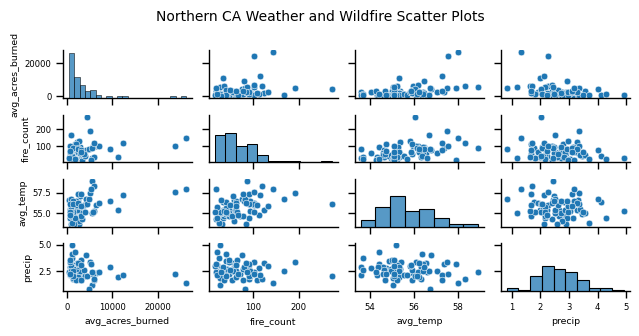

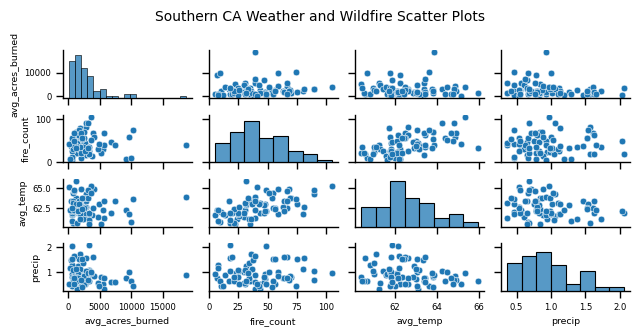

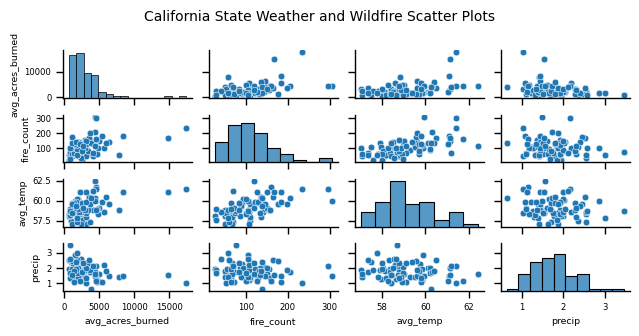

In [105]:
# Make the scatter plots compact
sns.set_context("paper", font_scale=0.7)
def plot_scatter(data_to_plot, title):
    grid = sns.pairplot(data_to_plot, height=0.8, aspect=2)
    grid.fig.suptitle(title, y=1.02, fontsize=10)
    grid.fig.tight_layout()

plot_scatter(norcal, "Northern CA Weather and Wildfire Scatter Plots")
plot_scatter(socal, "Southern CA Weather and Wildfire Scatter Plots")
plot_scatter(ca, "California State Weather and Wildfire Scatter Plots")

In [106]:
# Compute correlations
# Different variables have different distributions and only some have somewhat linear relationship
# in the scatterplots
# Still we will use the pearson correlation as the other methods did not do better 
norcal_corr = norcal.corr(method='pearson') 
socal_corr = socal.corr(method='pearson') 
ca_corr = ca.corr(method='pearson')
print("Northern California Correlations:\n", norcal_corr)
print("\nSothern California Correlations:\n", socal_corr)
print("\nCalifornia State Correlations:\n", ca_corr)

Northern California Correlations:
                   avg_acres_burned  fire_count  avg_temp    precip
avg_acres_burned          1.000000    0.313288  0.462136 -0.308006
fire_count                0.313288    1.000000  0.428218 -0.161490
avg_temp                  0.462136    0.428218  1.000000 -0.129629
precip                   -0.308006   -0.161490 -0.129629  1.000000

Sothern California Correlations:
                   avg_acres_burned  fire_count  avg_temp    precip
avg_acres_burned          1.000000    0.039978 -0.030208 -0.222691
fire_count                0.039978    1.000000  0.560875  0.037373
avg_temp                 -0.030208    0.560875  1.000000 -0.205403
precip                   -0.222691    0.037373 -0.205403  1.000000

California State Correlations:
                   avg_acres_burned  fire_count  avg_temp    precip
avg_acres_burned          1.000000    0.445010  0.437593 -0.338010
fire_count                0.445010    1.000000  0.574061 -0.126785
avg_temp                  

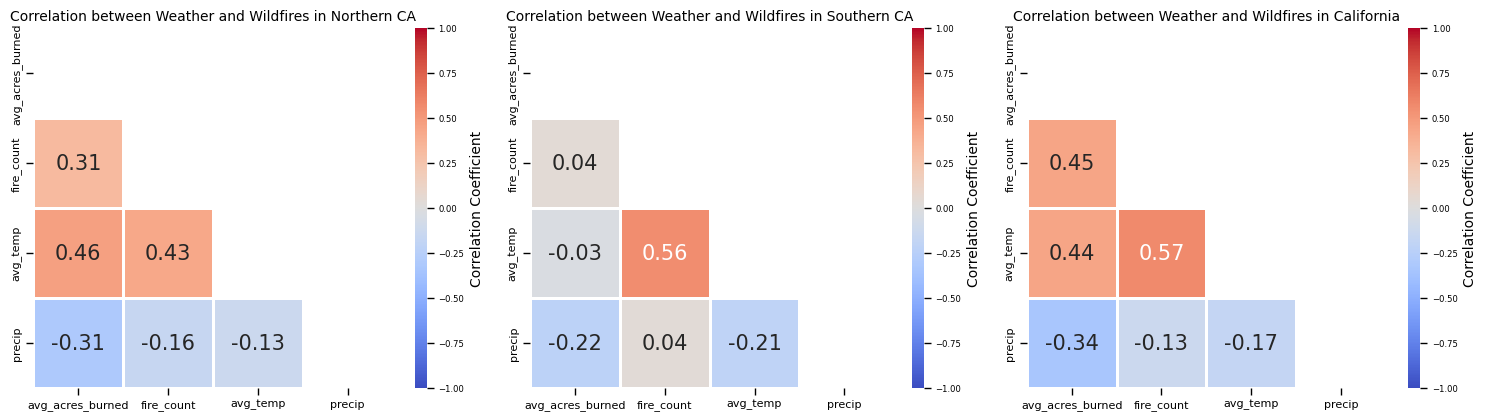

In [107]:
def plot_correlations(ax, data_to_plot, title, cbar=True):
    mask = np.triu(np.ones_like(data_to_plot, dtype=bool))
    sns.heatmap(data_to_plot, mask=mask,annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True,linewidth=1, ax=ax,
                cbar=cbar, cbar_kws={"shrink": 0.75, "aspect": 30}, annot_kws={"size": 15})
    ax_cbar = ax.collections[0].colorbar
    ax_cbar.set_label("Correlation Coefficient", fontsize=10)
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
   

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Do not need colorbars for the first two panel plots but plotting them so that all subplots have same size.
plot_correlations(axes[0], norcal_corr, "Correlation between Weather and Wildfires in Northern CA")
plot_correlations(axes[1], socal_corr, "Correlation between Weather and Wildfires in Southern CA")
plot_correlations(axes[2], ca_corr, "Correlation between Weather and Wildfires in California")
plt.tight_layout()
plt.show();

<font color="red"> <font size=4> Note: The analysis below considers **absolute** values of correlations of less than 0.25 indicative of no relationship between the variables, correlation between 0.25 to 0.5 as weak relationship, between 0.5 to 0.75 as moderate and above 0.75 as strong relationship. </font> 

<font color="purple"> <font size=4> **Average Temperature:** </font> 

<font color="purple"> <font size=3>    - There is a moderate positive correlation between yearly average temperature and number of fires in Southern California (0.56) and California (0.57) state as a whole. This correlation is slightly weaker in Northern California (0.43). This suggets that hotter years are slightly more favorable for higher wildfire activity in Southern California and California as a whole. </font>

<font color="purple"> <font size=3>    - There is a weak positive correlation between yearly average temperature and acres burned in Northern California (0.46) and California (0.44) state as a whole. This correlation is almost zero in Southern California (-0.03). This suggets that hotter years are slightly more favorable for large wildfires in Nothern California and California as a whole. </font>

<font color="purple"> <font size=3>    - This suggests that higher average temperatures influence wildfire activity differently in the two regions of California. In Northern California, higher temperatures are associated with more acres burned on average, whereas in Southern California, they are slightly more associated with a higher number of wildfires. </font>

<font color="purple"> <font size=4> **Precipitation:** </font> 

<font color="purple"> <font size=3>    - There is a weak negative correlation between yearly precipitation and acres burned in Norther CA (-0.31), Southern California (-0.22) and California (-0.34) state as a whole. </font>

<font color="purple"> <font size=3>    - There is zero or very weak negative correlation between yearly precipitation and number of wildfires in Norther CA (-0.16), Southern California (0.04) and California (-0.13) state as a whole. </font>

<font color="purple"> <font size=3>    - The above two points seem to suggest that drier years are slightly more favorable for larger wildfires in each region and the state as whole. But precipitation has less of an impact when it comes to number of wildfires.</font>

<font color="red"> <font size=4> **Note that whether a wildfire gets triggered and if triggered how large it grows depends on several factors such as temperature, precipitation, relative humidity, wind speeds, type of vegetation in the area, mitigation step taken to prevent wildfires. Here we are looking at only two factors - average temperature and precipitation - and that too at a coarser time (yearly) and spatial scales. So even if above correlation analysis gives us some insights it does not tell us the full story.** </font> 



### Univariate and Multivariate Linear Regression: California Average Temperature and Wildfire Count

<font color="purple"> <font size=4> I am interested in exploring the relationship between wildfire counts and average temperature in California. Our earlier exploratory analysis showed an upward trend in both the number of wildfires and average temperatures in recent years in California. Correlation analysis also revealed a moderate positive relationship between yearly average temperature and wildfire count, which makes sense physically and appears nearly linear in the scatterplot. To explore this further, I first built a univariate linear regression model using average temperature as the sole predictor. I then extended the analysis with a multivariate linear regression model that included additional variables to see if they significantly improved the model. </font>

<font color="red"> <font size=4> **Note: As mentioned earlier, wildfires are influenced by multiple factors. Even when weather and vegetation conditions are favorable, a wildfire may not occur without a trigger — such as downed power lines or human activity. Therefore, the goal of this regression analysis is to understand relationships between variables, not to predict specific wildfire events.** </font>

In [110]:
# Although not shown in this notebook, I experimented with various time derived variables
t = 1 + (ca.index - ca.index[0])
t_sq = t*t 
t_cos = np.cos(2*np.pi*t/12)
t_sin = np.sin(2*np.pi*t/12)

In [111]:
def plot_residuals(ax_row, data_to_plot, type_of_lr, label):
    ax = ax_row[0]
    ax.scatter(t, data_to_plot, color='b')
    ax.set_xlabel("Years since "+str(ca.index[0]))
    ax.set_ylabel("Residuals " + label)
    ax.set_title(type_of_lr + " Residuals vs. Time", fontsize=10)
    ax.grid(alpha=0.5)
    # Plot residuals histogram with normal distribution 
    plot_geo_dist(ax_row[1], data_to_plot, type_of_lr + " Residuals Histogram", "Residuals " + label, "Frequency", plot_gamma=False)

def multi_and_uni_lr(multi, uni, y, ylabel):

    multi_predictors = list(multi.values())
    multi_predictor_names = list(multi.keys())
    uni_predictor = list(uni.values())[0]
    uni_predictor_name = list(uni.keys())[0]

    print("\n\n------------------------------- Univariate Linear Regression -------------------------------")
    print("Predictor used:", uni_predictor_name)
    print("----------------------------------------------------------------------------------------------")
    y_pred_uni = linear_regression(uni_predictor, y)
    
    print("\n------------------------------- Multivariate Linear Regression -------------------------------")
    print("Predictors used:", multi_predictor_names)
    print("----------------------------------------------------------------------------------------------")
    y_pred_multi = linear_regression(np.transpose(multi_predictors), y)


    print("\n\n---------------------------------------- {} Linear Regression Plots -----------------------------------------".format(ylabel))
    # Multivariate vs Univariate Linear Regression
    fig,ax = plt.subplots(figsize=(15,4))
    ax.scatter(t, y, color='blue')
    ax.set_xlabel("Years since "+str(ca.index[0]))
    ax.set_ylabel(ylabel)
    ax.set_title("California Wildfires Linear Regression: " + ylabel, fontsize=10)
    mv_label = "multivariate (" + ', '.join(multi_predictor_names) + ")"
    ax.plot(t, y_pred_multi, color='black',linewidth=1,label=mv_label)
    
    uni_label = "univariate (" + uni_predictor_name + ")"
    ax.plot(t, y_pred_uni, "r--",linewidth=1,label=uni_label)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.5)

    # Plot residuals
    fig, axes = plt.subplots(2, 2, figsize=(15,4))
    # 2 X 2 panel plot; first row for univariate residuals. 2nd row for multivariate
    plot_residuals(axes[0], y - y_pred_uni, "Univariate", ylabel)
    plot_residuals(axes[1], y - y_pred_multi, "Multivariate", ylabel)
    plt.tight_layout()
    plt.show();



------------------------------- Univariate Linear Regression -------------------------------
Predictor used: avg_temp
----------------------------------------------------------------------------------------------
Linear regression model summary:
                             OLS Regression Results                            
Dep. Variable:             fire_count   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     35.88
Date:                Fri, 09 May 2025   Prob (F-statistic):           7.26e-08
Time:                        14:41:47   Log-Likelihood:                -391.83
No. Observations:                  75   AIC:                             787.7
Df Residuals:                      73   BIC:                             792.3
Df Model:                           1                                         
Covariance Type:            nonrobust   

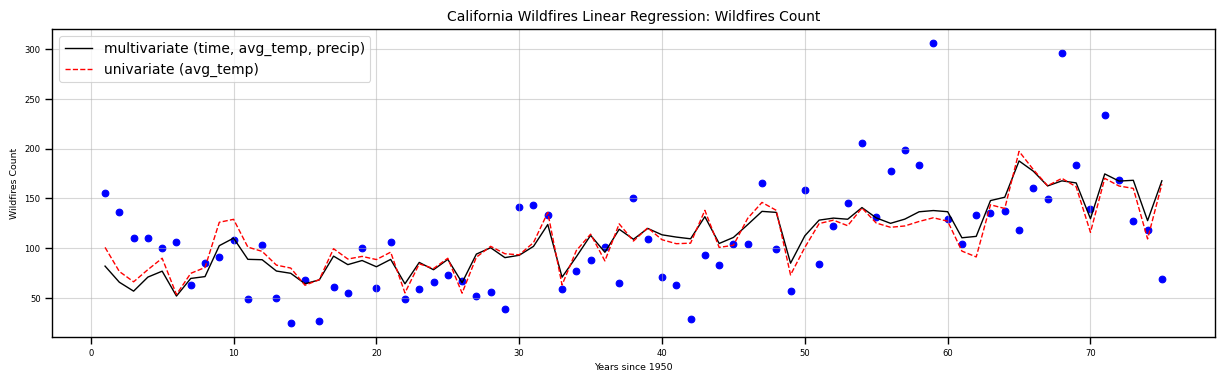

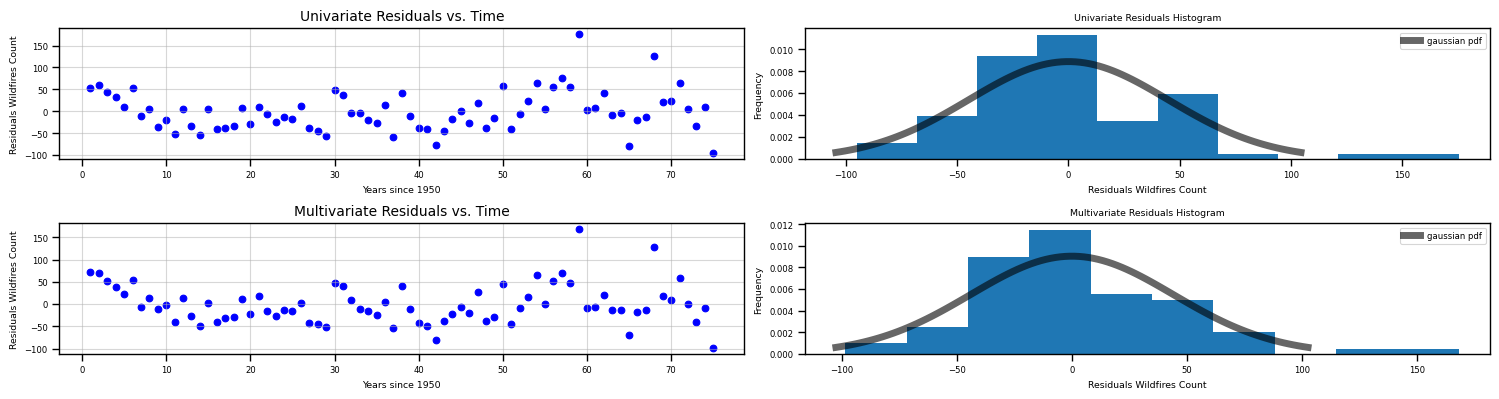

In [112]:
# Dependent variable: fire_count
# Univariate Linear Regression Predictor: avg_temp
# Multivariate Linear Regression Predictors: time (t), avg_temp, precip
multi_and_uni_lr({"time" : t, "avg_temp": ca["avg_temp"], "precip" : ca["precip"]}, {"avg_temp": ca["avg_temp"]}, 
                 np.squeeze(ca["fire_count"]), "Wildfires Count")

In [113]:
# mean and range for RMSE evaluation
print("Wildfire count mean: ", round(ca["fire_count"].mean(), 2))
print("Wildfire count range: ", round(ca["fire_count"].max() - ca["fire_count"].min(), 2))

Wildfire count mean:  110.31
Wildfire count range:  281


<font color="purple"> <font size=4> Interpretation of the Wildfire Count Regression Evaluation Metrics  </font>

| Evaluation Metric | Univariate Linear Regression (Predictor: avg_temp) | Multivariate Linear Regression (Predictors: ['time', 'avg_temp', 'precip'])|
|:--------:|:--------:|:--------:|
|  $R^{2}$   |  0.33 (i.e. 33% of the variataion in wildfire count around its mean is explained by this model)  |  0.35 (i.e. 35% of the variataion in wildfire count around its mean is explained by this model)  |
|  RMSE  |  44.94 (i.e. wildfire count predicted by this model can be off by 44-45 on average)  |  44.13 (i.e. wildfire count predicted by this model can be off by 44 on average)  |
|  p-values   |    0.000 (reject the null hypothesis; there is sufficient evidence that the regression coefficient for the the predictor avg_temp is statistically significant) |  0.006 for avg_temp but greater than 0.05 for other predictors (there is sufficient evidence that the regression coefficient for the the predictor avg_temp is statistically significant but not for other predictors - time and precipitation))  |

<font color="purple"> <font size=4> Patterns in the Residuals Plots: </font>

<font color="purple"> <font size=4> - Residual vs time plots for both the univariate and multivariate show some clusters and trends within. See more analysis in the note below.</font>

<font color="purple"> <font size=4> - Residual histograms for both the univariate and multivariate is almost normally distributed with zero mean. </font>

<font color="purple"> <font size=4> Based on the above analysis, univariate regression with *avg_temp* as the predictor performs comparable to the multivariate linear regression with additional predictors of *time* and *precipitation.* </font>

<font color="red"> <font size=4> However, note that neither model shows a good performance overall. Here are some of their limitations: </font>

<font color="red"> <font size=4>   - $R^{2}$ are very low and RMSEs are high (~16% of the wildfire count range and 40% of the mean) for both models.</font>

<font color="red"> <font size=4>   - The assumption is that residuals are independent, random variables that follow a normal distribution with mean of zero and constant variance (no pattern). However, there are some clusters in the residual vs time plots. This indicates that our assumption about the residuals is probably not met and the test mentioned earlier for statistical significance of regression coefficient may not be reliable. </font>

<font color="red"> <font size=4>   - The univariate and multivariate lines in the scatter plot seem to be overfitted. </font>

<font color="red"> <font size=4>   - Given that we are using wildfire *count* as dependent variable, idealy we should use Poisson regression for this analysis. </font>

## Conclusions based on Analysis done in this Project

- There has been an upward trend in both the number of wildfires and yearly average acres burned in recent years in California. The average temperature has steadily increased in California during the same period.
- Nine of California's ten largest wildfires between 1950 and early 2025 occurred relatively recently, between 2017 and 2020 and in Northern California.
- The hypothesis test showed strong evidence that Southern California tends to have more wildfires on average per year than Northern California. This makes sense physically because Southern California is typically hotter and drier than Northern California as we saw in this project.
- Correlation analysis revealed a moderate positive relationship between yearly average temperature and wildfire count.
- However, both the univariate linear regression model (using yearly average temperature as the predictor) and the multivariate model (which also includes time and precipitation) performed poorly across various evaluation metrics when wildfire count was used as the dependent variable. These models can be improved as described in the future work section.
- The above analysis ties back with the science objective mentioned earlier which was to *analyze the temporal and spatial characteristics of wildfires in California to answer questions such as: Has there been a rise in the number of wildfires in recent years? Which parts of California are more prone to wildfires? Are there correlations between wildfire activity and rising temperatures?*


## Future Work

- Use Poisson regression for the wildfire **count** regression analysis.
- Include additional predictors such as relative humidity, wind speed (which can also affect wildfires) to develop better regression models.
- Perform regression analysis at a granular temporal and spatial resolution. E.g. analyze conditions such as relative humidity, wind speed, temperature, and precipitation in the months leading up to each of the largest wildfires, focusing specifically on the areas surrounding where they occurred.
    - To conduct this analysis, we need granular temporal and spatial resolution weather data for relative humidity, wind speed, temperature, and precipitation.